# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 64  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 118453.578125
iteration 0 loss 97946.3046875


iteration 500 loss 368.9408874511719


iteration 1000 loss 322.09375


iteration 1500 loss 287.43804931640625


iteration 2000 loss 259.67425537109375


iteration 2500 loss 234.0128173828125


iteration 3000 loss 203.0999298095703


iteration 3500 loss 148.3938751220703


iteration 4000 loss 75.91238403320312


iteration 4500 loss 33.45111846923828


iteration 5000 loss 30.625917434692383


iteration 5500 loss 13.416119575500488


iteration 6000 loss 9.454527854919434


iteration 6500 loss 6.84808874130249


iteration 7000 loss 10.084792137145996


iteration 7500 loss 5.371581077575684


iteration 8000 loss 4.278226852416992


iteration 8500 loss 3.485584259033203


iteration 9000 loss 2.8145751953125


iteration 9500 loss 2.79868221282959


iteration 10000 loss 2.3166096210479736


iteration 10500 loss 1.9472347497940063


iteration 11000 loss 3.0002987384796143


iteration 11500 loss 2.07314133644104


iteration 12000 loss 1.7358355522155762


iteration 12500 loss 1.4954373836517334


iteration 13000 loss 16.6019287109375


iteration 13500 loss 1.557138442993164


iteration 14000 loss 1.2800076007843018


iteration 14500 loss 1.11251699924469


iteration 15000 loss 1.744873046875


iteration 15500 loss 1.0620043277740479


iteration 16000 loss 0.9170777797698975


iteration 16500 loss 1.8053642511367798


iteration 17000 loss 0.946291983127594


iteration 17500 loss 0.8063198924064636


iteration 18000 loss 0.7155893445014954


iteration 18500 loss 0.7497631311416626


iteration 19000 loss 0.6460287570953369


iteration 19500 loss 0.697401762008667


iteration 20000 loss 0.5912684202194214


iteration 20500 loss 0.7662717700004578


iteration 21000 loss 0.5697559714317322


iteration 21500 loss 0.5085763335227966


iteration 22000 loss 0.5583102107048035


iteration 22500 loss 0.4741937518119812


iteration 23000 loss 0.6899157166481018


iteration 23500 loss 0.4809055030345917


iteration 24000 loss 0.4202420711517334


iteration 24500 loss 0.4528307616710663


iteration 25000 loss 0.38480740785598755


iteration 25500 loss 0.45019394159317017


iteration 26000 loss 0.37081414461135864


iteration 26500 loss 0.46600788831710815


iteration 27000 loss 0.3474670946598053


iteration 27500 loss 0.4191123843193054


iteration 28000 loss 0.321856290102005


iteration 28500 loss 0.3421759605407715


iteration 29000 loss 0.3382194936275482


iteration 29500 loss 0.2932926416397095


iteration 30000 loss 0.29715433716773987


iteration 30500 loss 0.3913395404815674


iteration 31000 loss 0.26257508993148804


iteration 31500 loss 0.25331738591194153


iteration 32000 loss 0.26529568433761597


iteration 32500 loss 0.29442957043647766


iteration 33000 loss 0.2311726063489914


iteration 33500 loss 0.23427744209766388


iteration 34000 loss 0.23540112376213074


iteration 34500 loss 0.2900412082672119


iteration 35000 loss 0.20718663930892944


iteration 35500 loss 0.21131546795368195


iteration 36000 loss 0.2472400814294815


iteration 36500 loss 0.1914975792169571


iteration 37000 loss 0.19118385016918182


iteration 37500 loss 0.18552888929843903


iteration 38000 loss 0.18246345221996307


iteration 38500 loss 0.17498339712619781


iteration 39000 loss 0.16908039152622223


iteration 39500 loss 0.16627341508865356


iteration 40000 loss 0.4811345636844635


iteration 40500 loss 0.6132408976554871


iteration 41000 loss 0.47063061594963074


iteration 41500 loss 26.979873657226562


iteration 42000 loss 19.57748031616211


iteration 42500 loss 0.2014651596546173


iteration 43000 loss 0.18242044746875763


iteration 43500 loss 0.1849559247493744


iteration 44000 loss 0.17109443247318268


iteration 44500 loss 0.17000356316566467


iteration 45000 loss 0.1829683929681778


iteration 45500 loss 0.16602985560894012


iteration 46000 loss 0.13784170150756836


iteration 46500 loss 0.13269338011741638


iteration 47000 loss 0.12687259912490845


iteration 47500 loss 0.12387505918741226


iteration 48000 loss 0.11835239827632904


iteration 48500 loss 0.1174006462097168


iteration 49000 loss 0.11625710129737854


iteration 49500 loss 0.12425719946622849


iteration 50000 loss 0.11393298953771591


iteration 50500 loss 0.20355042815208435


iteration 51000 loss 0.1315724402666092


iteration 51500 loss 0.1129746288061142


iteration 52000 loss 0.10443935543298721


iteration 52500 loss 0.18217909336090088


iteration 53000 loss 0.11254487186670303


iteration 53500 loss 2.2787249088287354


iteration 54000 loss 0.10254243016242981


iteration 54500 loss 0.4935511648654938


iteration 55000 loss 0.12979909777641296


iteration 55500 loss 0.09882128983736038


iteration 56000 loss 0.09479404985904694


iteration 56500 loss 0.08959546685218811


iteration 57000 loss 29.59737205505371


iteration 57500 loss 0.10170887410640717


iteration 58000 loss 0.08978068083524704


iteration 58500 loss 0.4047684371471405


iteration 59000 loss 2.0957400798797607


iteration 59500 loss 0.10471897572278976


iteration 60000 loss 0.09718184918165207


iteration 60500 loss 0.08566653728485107


iteration 61000 loss 0.14494898915290833


iteration 61500 loss 0.09102091193199158


iteration 62000 loss 0.08205743879079819


iteration 62500 loss 59.207984924316406


iteration 63000 loss 0.0761328935623169


iteration 63500 loss 0.07971600443124771


iteration 64000 loss 11.6668119430542


iteration 64500 loss 0.07770229130983353


iteration 65000 loss 0.2143547236919403


iteration 65500 loss 0.07138609141111374


iteration 66000 loss 0.08402994275093079


iteration 66500 loss 0.07239602506160736


iteration 67000 loss 0.06960081309080124


iteration 67500 loss 0.06935618817806244


iteration 68000 loss 0.06677454710006714


iteration 68500 loss 0.06911475211381912


iteration 69000 loss 0.08149667829275131


iteration 69500 loss 0.06532474607229233


iteration 70000 loss 0.0698084756731987


iteration 70500 loss 0.09772291779518127


iteration 71000 loss 0.08067256212234497


iteration 71500 loss 0.06466267257928848


iteration 72000 loss 1.6834913492202759


iteration 72500 loss 0.06662014871835709


iteration 73000 loss 0.10570017993450165


iteration 73500 loss 2.053300619125366


iteration 74000 loss 4.305310249328613


iteration 74500 loss 0.20262287557125092


iteration 75000 loss 4.288639068603516


iteration 75500 loss 0.7310243248939514


iteration 76000 loss 0.184173122048378


iteration 76500 loss 7.023432731628418


iteration 77000 loss 4.529341697692871


iteration 77500 loss 0.08060244470834732


iteration 78000 loss 0.09026411920785904


iteration 78500 loss 2.4307868480682373


iteration 79000 loss 8.77785873413086


iteration 79500 loss 0.06248285993933678


iteration 80000 loss 0.1265031397342682


iteration 80500 loss 1.2329638004302979


iteration 81000 loss 9.967436790466309


iteration 81500 loss 2.6605331897735596


iteration 82000 loss 0.11771635711193085


iteration 82500 loss 0.11310677230358124


iteration 83000 loss 0.10177821666002274


iteration 83500 loss 0.4674170911312103


iteration 84000 loss 0.31688740849494934


iteration 84500 loss 0.19666925072669983


iteration 85000 loss 0.06545376777648926


iteration 85500 loss 0.21453911066055298


iteration 86000 loss 0.2388962358236313


iteration 86500 loss 0.051164411008358


iteration 87000 loss 0.3317176103591919


iteration 87500 loss 0.1931440383195877


iteration 88000 loss 0.4622862637042999


iteration 88500 loss 5.4260125160217285


iteration 89000 loss 1.874537467956543


iteration 89500 loss 9.193123817443848


iteration 90000 loss 0.21376876533031464


iteration 90500 loss 0.9671370983123779


iteration 91000 loss 7.673796653747559


iteration 91500 loss 0.18655915558338165


iteration 92000 loss 4.701706409454346


iteration 92500 loss 0.278775691986084


iteration 93000 loss 7.864534378051758


iteration 93500 loss 1.33077871799469


iteration 94000 loss 1.6786714792251587


iteration 94500 loss 0.055808115750551224


iteration 95000 loss 1.4710391759872437


iteration 95500 loss 0.2229575365781784


iteration 96000 loss 0.27098533511161804


iteration 96500 loss 0.35393595695495605


iteration 97000 loss 0.3048763573169708


iteration 97500 loss 1.043458342552185


iteration 98000 loss 6.32197904586792


iteration 98500 loss 0.043978553265333176


iteration 99000 loss 0.5716856718063354


iteration 99500 loss 0.0836801528930664


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 1.0829846858978271


iteration 100500 loss 0.035948529839515686


iteration 101000 loss 0.034170001745224


iteration 101500 loss 0.032836221158504486


iteration 102000 loss 0.031674038618803024


iteration 102500 loss 0.030568642541766167


iteration 103000 loss 0.029477586969733238


iteration 103500 loss 0.028376799076795578


iteration 104000 loss 0.027247777208685875


iteration 104500 loss 0.026075152680277824


iteration 105000 loss 0.025632329285144806


iteration 105500 loss 0.024219036102294922


iteration 106000 loss 0.09180288761854172


iteration 106500 loss 0.02269279584288597


iteration 107000 loss 0.022000694647431374


iteration 107500 loss 0.02138226479291916


iteration 108000 loss 0.022742941975593567


iteration 108500 loss 0.020258240401744843


iteration 109000 loss 0.019767172634601593


iteration 109500 loss 0.01929856278002262


iteration 110000 loss 0.01882709003984928


iteration 110500 loss 0.018376950174570084


iteration 111000 loss 0.018013296648859978


iteration 111500 loss 0.01762022078037262


iteration 112000 loss 0.0172453373670578


iteration 112500 loss 0.020164398476481438


iteration 113000 loss 0.02050291746854782


iteration 113500 loss 0.01617516204714775


iteration 114000 loss 0.37735065817832947


iteration 114500 loss 0.015533464960753918


iteration 115000 loss 0.015225733630359173


iteration 115500 loss 0.018338877707719803


iteration 116000 loss 0.014626833610236645


iteration 116500 loss 0.014344796538352966


iteration 117000 loss 0.014383706264197826


iteration 117500 loss 0.013824621215462685


iteration 118000 loss 0.013599769212305546


iteration 118500 loss 0.013593310490250587


iteration 119000 loss 0.013089864514768124


iteration 119500 loss 0.013239260762929916


iteration 120000 loss 0.013256102800369263


iteration 120500 loss 0.012385132722556591


iteration 121000 loss 0.012220615521073341


iteration 121500 loss 0.012120961211621761


iteration 122000 loss 0.011729933321475983


iteration 122500 loss 0.011529664508998394


iteration 123000 loss 0.01133438479155302


iteration 123500 loss 0.012799293734133244


iteration 124000 loss 0.010947181843221188


iteration 124500 loss 0.010785907506942749


iteration 125000 loss 0.010654167272150517


iteration 125500 loss 0.010406159795820713


iteration 126000 loss 0.010233140550553799


iteration 126500 loss 0.01011503767222166


iteration 127000 loss 0.010798894800245762


iteration 127500 loss 0.009762718342244625


iteration 128000 loss 0.009640323929488659


iteration 128500 loss 0.009434476494789124


iteration 129000 loss 0.009278036653995514


iteration 129500 loss 0.009185059927403927


iteration 130000 loss 0.008988871239125729


iteration 130500 loss 0.008877941407263279


iteration 131000 loss 0.008815421722829342


iteration 131500 loss 0.008569515310227871


iteration 132000 loss 0.008445479907095432


iteration 132500 loss 0.008527671918272972


iteration 133000 loss 0.00818018801510334


iteration 133500 loss 0.008060025982558727


iteration 134000 loss 0.10548019409179688


iteration 134500 loss 0.007813363336026669


iteration 135000 loss 0.007709129247814417


iteration 135500 loss 0.023944661021232605


iteration 136000 loss 0.0074710538610816


iteration 136500 loss 0.007353603839874268


iteration 137000 loss 0.007257815450429916


iteration 137500 loss 0.007941619493067265


iteration 138000 loss 0.007035715971142054


iteration 138500 loss 0.007087679114192724


iteration 139000 loss 0.006843613460659981


iteration 139500 loss 0.006788605358451605


iteration 140000 loss 0.006998911965638399


iteration 140500 loss 0.007023177109658718


iteration 141000 loss 0.006447448395192623


iteration 141500 loss 0.006349749863147736


iteration 142000 loss 0.006260845344513655


iteration 142500 loss 0.006191759370267391


iteration 143000 loss 0.006874951533973217


iteration 143500 loss 0.005993117578327656


iteration 144000 loss 0.005941090174019337


iteration 144500 loss 0.006075612269341946


iteration 145000 loss 0.0057471455074846745


iteration 145500 loss 0.005666046869009733


iteration 146000 loss 0.005592507775872946


iteration 146500 loss 0.005559758748859167


iteration 147000 loss 0.0070782736875116825


iteration 147500 loss 0.005356596317142248


iteration 148000 loss 0.005278580356389284


iteration 148500 loss 0.0052160839550197124


iteration 149000 loss 0.005426205229014158


iteration 149500 loss 0.00506472447887063


iteration 150000 loss 0.004993041045963764


iteration 150500 loss 0.004930408205837011


iteration 151000 loss 0.004880216438323259


iteration 151500 loss 0.042628925293684006


iteration 152000 loss 0.004852434620261192


iteration 152500 loss 0.004662321414798498


iteration 153000 loss 0.004604144021868706


iteration 153500 loss 0.004562693648040295


iteration 154000 loss 0.06801652908325195


iteration 154500 loss 0.004467869643121958


iteration 155000 loss 0.004352770280092955


iteration 155500 loss 0.004295408260077238


iteration 156000 loss 0.0042465864680707455


iteration 156500 loss 0.00422050291672349


iteration 157000 loss 0.04164547473192215


iteration 157500 loss 0.004142669029533863


iteration 158000 loss 0.006512908730655909


iteration 158500 loss 0.004038617014884949


iteration 159000 loss 0.0039137196727097034


iteration 159500 loss 0.0038627127651125193


iteration 160000 loss 0.003812226001173258


iteration 160500 loss 0.0038119438104331493


iteration 161000 loss 0.003720159875229001


iteration 161500 loss 0.0036896681413054466


iteration 162000 loss 0.003929592669010162


iteration 162500 loss 0.08605600148439407


iteration 163000 loss 0.0050794994458556175


iteration 163500 loss 0.003918022848665714


iteration 164000 loss 0.0034472811967134476


iteration 164500 loss 0.0033907820470631123


iteration 165000 loss 0.0033501647412776947


iteration 165500 loss 0.003310723463073373


iteration 166000 loss 0.003276779782027006


iteration 166500 loss 0.003238309407606721


iteration 167000 loss 0.0032061277888715267


iteration 167500 loss 0.0031672229524701834


iteration 168000 loss 0.003118267050012946


iteration 168500 loss 0.003103496041148901


iteration 169000 loss 0.00873724464327097


iteration 169500 loss 0.005531903821974993


iteration 170000 loss 0.0030318826902657747


iteration 170500 loss 0.004951741546392441


iteration 171000 loss 0.0028748298063874245


iteration 171500 loss 0.0028445213101804256


iteration 172000 loss 0.0028282117564231157


iteration 172500 loss 0.003989491146057844


iteration 173000 loss 0.00497791962698102


iteration 173500 loss 0.0029035541228950024


iteration 174000 loss 0.002699463628232479


iteration 174500 loss 0.0027344808913767338


iteration 175000 loss 0.002621860709041357


iteration 175500 loss 0.0026432250160723925


iteration 176000 loss 0.053499169647693634


iteration 176500 loss 0.013321454636752605


iteration 177000 loss 0.0025024672504514456


iteration 177500 loss 0.002462725155055523


iteration 178000 loss 0.0024125012569129467


iteration 178500 loss 0.002923218533396721


iteration 179000 loss 0.0023744129575788975


iteration 179500 loss 0.0024738323409110308


iteration 180000 loss 0.0030378387309610844


iteration 180500 loss 0.0030676338355988264


iteration 181000 loss 0.0028273749630898237


iteration 181500 loss 0.0024261889047920704


iteration 182000 loss 0.002203066600486636


iteration 182500 loss 0.0021676744800060987


iteration 183000 loss 0.002141243778169155


iteration 183500 loss 0.002123641548678279


iteration 184000 loss 0.002093728631734848


iteration 184500 loss 0.228981614112854


iteration 185000 loss 0.0020525443833321333


iteration 185500 loss 0.010516171343624592


iteration 186000 loss 0.0019892104901373386


iteration 186500 loss 0.0019685064908117056


iteration 187000 loss 0.0023594240192323923


iteration 187500 loss 0.0019253474893048406


iteration 188000 loss 0.0018944484181702137


iteration 188500 loss 0.0019078159239143133


iteration 189000 loss 0.001889679697342217


iteration 189500 loss 0.01683015376329422


iteration 190000 loss 0.03583701699972153


iteration 190500 loss 0.003884384874254465


iteration 191000 loss 0.05682673305273056


iteration 191500 loss 0.004212843254208565


iteration 192000 loss 0.0017207732889801264


iteration 192500 loss 0.001707739196717739


iteration 193000 loss 0.002723389072343707


iteration 193500 loss 0.00226411665789783


iteration 194000 loss 0.0016479050973430276


iteration 194500 loss 0.0016162646934390068


iteration 195000 loss 0.0017476646462455392


iteration 195500 loss 0.004704117774963379


iteration 196000 loss 0.0030224777292460203


iteration 196500 loss 0.0015416379319503903


iteration 197000 loss 0.0015234170714393258


iteration 197500 loss 0.0017017856007441878


iteration 198000 loss 0.0017926006112247705


iteration 198500 loss 0.26382216811180115


iteration 199000 loss 0.001456869300454855


iteration 199500 loss 0.001442507142201066


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0025620919186621904


iteration 200500 loss 0.0014267221558839083


iteration 201000 loss 0.0014186949701979756


iteration 201500 loss 0.0014118128456175327


iteration 202000 loss 0.0014056973159313202


iteration 202500 loss 0.0013995066983625293


iteration 203000 loss 0.0013923990773037076


iteration 203500 loss 0.0013838098384439945


iteration 204000 loss 0.001373116858303547


iteration 204500 loss 0.0013596490025520325


iteration 205000 loss 0.0013551528099924326


iteration 205500 loss 0.0013295253738760948


iteration 206000 loss 0.001317524933256209


iteration 206500 loss 0.0013036859454587102


iteration 207000 loss 0.0012884467141702771


iteration 207500 loss 0.0012763070408254862


iteration 208000 loss 0.001265611732378602


iteration 208500 loss 0.0012481198646128178


iteration 209000 loss 0.001236679032444954


iteration 209500 loss 0.001225962769240141


iteration 210000 loss 0.0012160824844613671


iteration 210500 loss 0.0011983058648183942


iteration 211000 loss 0.001186462352052331


iteration 211500 loss 0.0011786601971834898


iteration 212000 loss 0.0011612187372520566


iteration 212500 loss 0.0011497547384351492


iteration 213000 loss 0.001141385524533689


iteration 213500 loss 0.001125113107264042


iteration 214000 loss 0.001114178099669516


iteration 214500 loss 0.005229209084063768


iteration 215000 loss 0.0010901490459218621


iteration 215500 loss 0.0010779693257063627


iteration 216000 loss 0.0010667783208191395


iteration 216500 loss 0.0010569891892373562


iteration 217000 loss 0.0010610187891870737


iteration 217500 loss 0.0010344533948227763


iteration 218000 loss 0.0010245306184515357


iteration 218500 loss 0.0010133866453543305


iteration 219000 loss 0.0010030545527115464


iteration 219500 loss 0.0009960582247003913


iteration 220000 loss 0.0009822027059271932


iteration 220500 loss 0.0009727901197038591


iteration 221000 loss 0.000969834509305656


iteration 221500 loss 0.0009587032836861908


iteration 222000 loss 0.0009434301173314452


iteration 222500 loss 0.0009344304562546313


iteration 223000 loss 0.000931279850192368


iteration 223500 loss 0.0009149482357315719


iteration 224000 loss 0.000905814697034657


iteration 224500 loss 0.0008969150367192924


iteration 225000 loss 0.0008876155479811132


iteration 225500 loss 0.0008786325925029814


iteration 226000 loss 0.0008694740245118737


iteration 226500 loss 0.000860633619595319


iteration 227000 loss 0.0008508593309670687


iteration 227500 loss 0.0008426002459600568


iteration 228000 loss 0.0008345647365786135


iteration 228500 loss 0.0008250483078882098


iteration 229000 loss 0.0008175421389751136


iteration 229500 loss 0.0008093768847174942


iteration 230000 loss 0.0010042774956673384


iteration 230500 loss 0.0007930653518997133


iteration 231000 loss 0.0007851906702853739


iteration 231500 loss 0.0007766459020785987


iteration 232000 loss 0.0007688890909776092


iteration 232500 loss 0.0007842606864869595


iteration 233000 loss 0.0007533560274168849


iteration 233500 loss 0.0007464953232556581


iteration 234000 loss 0.0007395247230306268


iteration 234500 loss 0.0007312269881367683


iteration 235000 loss 0.0007244965527206659


iteration 235500 loss 0.0007167659350670874


iteration 236000 loss 0.0007095530163496733


iteration 236500 loss 0.000703029683791101


iteration 237000 loss 0.0006948830559849739


iteration 237500 loss 0.0006882685120217502


iteration 238000 loss 0.0006919449078850448


iteration 238500 loss 0.0006743679405190051


iteration 239000 loss 0.0006678570643998682


iteration 239500 loss 0.0021518294233828783


iteration 240000 loss 0.0006544745992869139


iteration 240500 loss 0.0006488824728876352


iteration 241000 loss 0.0006540690083056688


iteration 241500 loss 0.0006351846386678517


iteration 242000 loss 0.0006295706261880696


iteration 242500 loss 0.000635230157058686


iteration 243000 loss 0.0006166095845401287


iteration 243500 loss 0.0006451952503994107


iteration 244000 loss 0.0006042656605131924


iteration 244500 loss 0.0005983884329907596


iteration 245000 loss 0.0005922167911194265


iteration 245500 loss 0.0005864693666808307


iteration 246000 loss 0.000580953317694366


iteration 246500 loss 0.0009864844614639878


iteration 247000 loss 0.0005693514831364155


iteration 247500 loss 0.0005634527769871056


iteration 248000 loss 0.0005579964490607381


iteration 248500 loss 0.0005525385495275259


iteration 249000 loss 0.0005469736061058939


iteration 249500 loss 0.0005415454506874084


iteration 250000 loss 0.0005366309778764844


iteration 250500 loss 0.0005354281165637076


iteration 251000 loss 0.0005260756588540971


iteration 251500 loss 0.0005210862727835774


iteration 252000 loss 0.018722884356975555


iteration 252500 loss 0.0005107590695843101


iteration 253000 loss 0.0005444615380838513


iteration 253500 loss 0.0005007779109291732


iteration 254000 loss 0.0004959592479281127


iteration 254500 loss 0.0004919065395370126


iteration 255000 loss 0.0004860235203523189


iteration 255500 loss 0.0004818011075258255


iteration 256000 loss 0.00047758815344423056


iteration 256500 loss 0.0004719826683867723


iteration 257000 loss 0.0004759548173751682


iteration 257500 loss 0.00046253230539150536


iteration 258000 loss 0.00046279828529804945


iteration 258500 loss 0.000453692366136238


iteration 259000 loss 0.0004490430583246052


iteration 259500 loss 0.0004443350189831108


iteration 260000 loss 0.0004402313206810504


iteration 260500 loss 0.00043623847886919975


iteration 261000 loss 0.0004360140301287174


iteration 261500 loss 0.00042760977521538734


iteration 262000 loss 0.00042568452772684395


iteration 262500 loss 0.00041954321204684675


iteration 263000 loss 0.00041542481631040573


iteration 263500 loss 0.00041831177077256143


iteration 264000 loss 0.0004072666051797569


iteration 264500 loss 0.00040341613930650055


iteration 265000 loss 0.00040094746509566903


iteration 265500 loss 0.00039533060044050217


iteration 266000 loss 0.003893533255904913


iteration 266500 loss 0.0003877788258250803


iteration 267000 loss 0.00038709156797267497


iteration 267500 loss 0.0003812106151599437


iteration 268000 loss 0.0003767237940337509


iteration 268500 loss 0.00037295036599971354


iteration 269000 loss 0.00036917533725500107


iteration 269500 loss 0.008353970013558865


iteration 270000 loss 0.0003618804912548512


iteration 270500 loss 0.00036198709858581424


iteration 271000 loss 0.0003549113171175122


iteration 271500 loss 0.000351705210050568


iteration 272000 loss 0.0003486218338366598


iteration 272500 loss 0.0003447489289101213


iteration 273000 loss 0.0003567049279808998


iteration 273500 loss 0.0003382558352313936


iteration 274000 loss 0.0003355339867994189


iteration 274500 loss 0.0003311817708890885


iteration 275000 loss 0.0003286291903350502


iteration 275500 loss 0.00032595102675259113


iteration 276000 loss 0.00032585783628746867


iteration 276500 loss 0.0003192703006789088


iteration 277000 loss 0.00033024215372279286


iteration 277500 loss 0.0003130743280053139


iteration 278000 loss 0.0003103375784121454


iteration 278500 loss 0.0003074010892305523


iteration 279000 loss 0.00030410956242121756


iteration 279500 loss 0.0003035837144125253


iteration 280000 loss 0.0002985097235068679


iteration 280500 loss 0.00029561002156697214


iteration 281000 loss 0.0003655431210063398


iteration 281500 loss 0.00029000930953770876


iteration 282000 loss 0.0002913253556471318


iteration 282500 loss 0.0002846154966391623


iteration 283000 loss 0.0002817718777805567


iteration 283500 loss 0.0003253119357395917


iteration 284000 loss 0.00027645830414257944


iteration 284500 loss 0.00027469982160255313


iteration 285000 loss 0.0002713933354243636


iteration 285500 loss 0.0002686858642846346


iteration 286000 loss 0.00027029719785787165


iteration 286500 loss 0.00026343658100813627


iteration 287000 loss 0.006604472175240517


iteration 287500 loss 0.00025850185193121433


iteration 288000 loss 0.0002558872802183032


iteration 288500 loss 0.0002539218112360686


iteration 289000 loss 0.00025133119197562337


iteration 289500 loss 0.00027441701968200505


iteration 290000 loss 0.00024710578145459294


iteration 290500 loss 0.0002445686259306967


iteration 291000 loss 0.0002437798393657431


iteration 291500 loss 0.0002397095668129623


iteration 292000 loss 0.00023925797722768039


iteration 292500 loss 0.0002351958682993427


iteration 293000 loss 0.00023544454597868025


iteration 293500 loss 0.00023081159451976418


iteration 294000 loss 0.0002287221432197839


iteration 294500 loss 0.0002265637886011973


iteration 295000 loss 0.00022424104099627584


iteration 295500 loss 0.00022335586254484951


iteration 296000 loss 0.00022007024381309748


iteration 296500 loss 0.0002181000163545832


iteration 297000 loss 0.00021601833577733487


iteration 297500 loss 0.00022001304023433477


iteration 298000 loss 0.00021294865291565657


iteration 298500 loss 0.0002099462872138247


iteration 299000 loss 0.0002078873512800783


iteration 299500 loss 0.00020581197168212384


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0002281868364661932


iteration 300500 loss 0.0002045581495622173


iteration 301000 loss 0.00020399343338795006


iteration 301500 loss 0.00020349265832919627


iteration 302000 loss 0.00020301894983276725


iteration 302500 loss 0.00020251597743481398


iteration 303000 loss 0.00020193023374304175


iteration 303500 loss 0.00020118577231187373


iteration 304000 loss 0.00020023035176564008


iteration 304500 loss 0.00019899909966625273


iteration 305000 loss 0.00019741967844311148


iteration 305500 loss 0.00019542522204574198


iteration 306000 loss 0.0001929366117110476


iteration 306500 loss 0.000191790284588933


iteration 307000 loss 0.00019047828391194344


iteration 307500 loss 0.00018880570132751018


iteration 308000 loss 0.00018674213788472116


iteration 308500 loss 0.00018513420945964754


iteration 309000 loss 0.00018383107089903206


iteration 309500 loss 0.00018220434139948338


iteration 310000 loss 0.00018007057951763272


iteration 310500 loss 0.0001782785402610898


iteration 311000 loss 0.00017725884390529245


iteration 311500 loss 0.00017594439850654453


iteration 312000 loss 0.00017426074191462249


iteration 312500 loss 0.00017210350779350847


iteration 313000 loss 0.00017102867423091084


iteration 313500 loss 0.00016991073789540678


iteration 314000 loss 0.0001684692397248


iteration 314500 loss 0.00016666034935042262


iteration 315000 loss 0.00016480479098390788


iteration 315500 loss 0.0001638327375985682


iteration 316000 loss 0.0001625827862881124


iteration 316500 loss 0.0001611641055205837


iteration 317000 loss 0.00015895947581157088


iteration 317500 loss 0.00015795031504239887


iteration 318000 loss 0.00015688108396716416


iteration 318500 loss 0.00015552080003544688


iteration 319000 loss 0.00015372147026937455


iteration 319500 loss 0.00015255708422046155


iteration 320000 loss 0.000151519532664679


iteration 320500 loss 0.00015019926649983972


iteration 321000 loss 0.00014870977611280978


iteration 321500 loss 0.00014728677342645824


iteration 322000 loss 0.00014634229592047632


iteration 322500 loss 0.00014512307825498283


iteration 323000 loss 0.00014372169971466064


iteration 323500 loss 0.00014210566587280482


iteration 324000 loss 0.00014130942872725427


iteration 324500 loss 0.0001402534981025383


iteration 325000 loss 0.00013895062147639692


iteration 325500 loss 0.0001384099159622565


iteration 326000 loss 0.00013645683065988123


iteration 326500 loss 0.00013539104838855565


iteration 327000 loss 0.0001341476454399526


iteration 327500 loss 0.0001326997735304758


iteration 328000 loss 0.00013145210687071085


iteration 328500 loss 0.00013071384455543011


iteration 329000 loss 0.0001297413109568879


iteration 329500 loss 0.00012864696327596903


iteration 330000 loss 0.00012689709546975791


iteration 330500 loss 0.00012602841889020056


iteration 331000 loss 0.00012523260375019163


iteration 331500 loss 0.00012419089034665376


iteration 332000 loss 0.00012284494005143642


iteration 332500 loss 0.00012166322267148644


iteration 333000 loss 0.0001209254696732387


iteration 333500 loss 0.00011995651584584266


iteration 334000 loss 0.00011872928007505834


iteration 334500 loss 0.000257280160440132


iteration 335000 loss 0.00011661176540656015


iteration 335500 loss 0.00011592050577746704


iteration 336000 loss 0.00011502835695864633


iteration 336500 loss 0.00011390963481971994


iteration 337000 loss 0.00011306992382742465


iteration 337500 loss 0.00011189020733581856


iteration 338000 loss 0.00011111875210190192


iteration 338500 loss 0.00011012506001861766


iteration 339000 loss 0.000108853739220649


iteration 339500 loss 0.00010810400999616832


iteration 340000 loss 0.00010739825665950775


iteration 340500 loss 0.00010649901378201321


iteration 341000 loss 0.00010537235357332975


iteration 341500 loss 0.00010425599612062797


iteration 342000 loss 0.00010365918569732457


iteration 342500 loss 0.00010288346675224602


iteration 343000 loss 0.00010192198533331975


iteration 343500 loss 0.00011331686982885003


iteration 344000 loss 0.00010007644596043974


iteration 344500 loss 9.938014409272e-05


iteration 345000 loss 9.848926129052415e-05


iteration 345500 loss 9.732637408887967e-05


iteration 346000 loss 9.655499889049679e-05


iteration 346500 loss 9.598632459528744e-05


iteration 347000 loss 9.524495544610545e-05


iteration 347500 loss 9.435998799744993e-05


iteration 348000 loss 9.319506352767348e-05


iteration 348500 loss 9.262173989554867e-05


iteration 349000 loss 9.212725854013115e-05


iteration 349500 loss 9.14794800337404e-05


iteration 350000 loss 9.068322106031701e-05


iteration 350500 loss 8.974364027380943e-05


iteration 351000 loss 8.900800457922742e-05


iteration 351500 loss 8.836943015921861e-05


iteration 352000 loss 8.759224147070199e-05


iteration 352500 loss 8.652448741486296e-05


iteration 353000 loss 8.588076889282092e-05


iteration 353500 loss 8.53854144224897e-05


iteration 354000 loss 8.474378410028294e-05


iteration 354500 loss 8.393435564357787e-05


iteration 355000 loss 8.543804142391309e-05


iteration 355500 loss 8.24530579848215e-05


iteration 356000 loss 8.188273932319134e-05


iteration 356500 loss 8.116949902614579e-05


iteration 357000 loss 8.020757377380505e-05


iteration 357500 loss 7.952621672302485e-05


iteration 358000 loss 7.913503213785589e-05


iteration 358500 loss 7.862026541261002e-05


iteration 359000 loss 7.793985423631966e-05


iteration 359500 loss 7.71168342907913e-05


iteration 360000 loss 7.636135705979541e-05


iteration 360500 loss 7.593233021907508e-05


iteration 361000 loss 7.536332122981548e-05


iteration 361500 loss 7.462758367182687e-05


iteration 362000 loss 7.370659295702353e-05


iteration 362500 loss 7.328637730097398e-05


iteration 363000 loss 7.291050860658288e-05


iteration 363500 loss 7.240420382004231e-05


iteration 364000 loss 7.176886720117182e-05


iteration 364500 loss 7.155149069149047e-05


iteration 365000 loss 7.047312828944996e-05


iteration 365500 loss 6.99279407854192e-05


iteration 366000 loss 6.923563341842964e-05


iteration 366500 loss 6.86835337546654e-05


iteration 367000 loss 6.806488818256184e-05


iteration 367500 loss 6.764707359252498e-05


iteration 368000 loss 6.717105861753225e-05


iteration 368500 loss 6.639976345468313e-05


iteration 369000 loss 6.567117088707164e-05


iteration 369500 loss 6.53369352221489e-05


iteration 370000 loss 6.492035754490644e-05


iteration 370500 loss 6.436146213673055e-05


iteration 371000 loss 6.374175427481532e-05


iteration 371500 loss 6.316528742900118e-05


iteration 372000 loss 6.275164923863485e-05


iteration 372500 loss 6.222040246939287e-05


iteration 373000 loss 6.152258720248938e-05


iteration 373500 loss 6.107061926741153e-05


iteration 374000 loss 6.070154267945327e-05


iteration 374500 loss 6.0247180954320356e-05


iteration 375000 loss 5.9614252677420154e-05


iteration 375500 loss 5.90328018006403e-05


iteration 376000 loss 5.870041059097275e-05


iteration 376500 loss 5.825655171065591e-05


iteration 377000 loss 5.7677494623931125e-05


iteration 377500 loss 5.7118591939797625e-05


iteration 378000 loss 5.677637818735093e-05


iteration 378500 loss 5.6309923820663244e-05


iteration 379000 loss 5.5722324759699404e-05


iteration 379500 loss 5.515345765161328e-05


iteration 380000 loss 5.4869447922101244e-05


iteration 380500 loss 5.452804543892853e-05


iteration 381000 loss 5.4079842811916023e-05


iteration 381500 loss 5.348602280719206e-05


iteration 382000 loss 5.3039002523291856e-05


iteration 382500 loss 5.275201692711562e-05


iteration 383000 loss 5.236833021626808e-05


iteration 383500 loss 5.198912549531087e-05


iteration 384000 loss 5.121587309986353e-05


iteration 384500 loss 5.094594234833494e-05


iteration 385000 loss 5.0670383643591776e-05


iteration 385500 loss 5.0310562073718756e-05


iteration 386000 loss 4.983500184607692e-05


iteration 386500 loss 4.935665492666885e-05


iteration 387000 loss 4.900962449028157e-05


iteration 387500 loss 4.8624900955474004e-05


iteration 388000 loss 4.819579771719873e-05


iteration 388500 loss 4.763003016705625e-05


iteration 389000 loss 4.738332063425332e-05


iteration 389500 loss 4.7092584281926975e-05


iteration 390000 loss 4.679202174884267e-05


iteration 390500 loss 4.636529047274962e-05


iteration 391000 loss 4.585904753184877e-05


iteration 391500 loss 4.5590641093440354e-05


iteration 392000 loss 4.523872121353634e-05


iteration 392500 loss 4.500164504861459e-05


iteration 393000 loss 4.433066351339221e-05


iteration 393500 loss 4.4095286284573376e-05


iteration 394000 loss 4.3806929170386866e-05


iteration 394500 loss 4.3410258513176814e-05


iteration 395000 loss 4.29011088272091e-05


iteration 395500 loss 4.2646370275178924e-05


iteration 396000 loss 4.240675480104983e-05


iteration 396500 loss 4.209439430269413e-05


iteration 397000 loss 4.1644398152129725e-05


iteration 397500 loss 4.123992766835727e-05


iteration 398000 loss 4.09977110393811e-05


iteration 398500 loss 4.0745624573901296e-05


iteration 399000 loss 4.040936619276181e-05


iteration 399500 loss 4.0085877117235214e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.966057192883454e-05


iteration 400500 loss 3.965602081734687e-05


iteration 401000 loss 3.9647147787036374e-05


iteration 401500 loss 3.963203198509291e-05


iteration 402000 loss 3.9611535612493753e-05


iteration 402500 loss 3.957775697926991e-05


iteration 403000 loss 3.9524762541987e-05


iteration 403500 loss 3.945302887586877e-05


iteration 404000 loss 3.934804772143252e-05


iteration 404500 loss 3.920113522326574e-05


iteration 405000 loss 3.900399315170944e-05


iteration 405500 loss 3.8736667193006724e-05


iteration 406000 loss 3.837465919787064e-05


iteration 406500 loss 3.791225026361644e-05


iteration 407000 loss 3.7577257899101824e-05


iteration 407500 loss 3.734524216270074e-05


iteration 408000 loss 3.7028174119768664e-05


iteration 408500 loss 3.660919901449233e-05


iteration 409000 loss 3.621426731115207e-05


iteration 409500 loss 3.602847209549509e-05


iteration 410000 loss 3.577980169211514e-05


iteration 410500 loss 3.5441480576992035e-05


iteration 411000 loss 3.500090315355919e-05


iteration 411500 loss 3.473891410976648e-05


iteration 412000 loss 3.4540382330305874e-05


iteration 412500 loss 3.4264943678863347e-05


iteration 413000 loss 3.38944373652339e-05


iteration 413500 loss 3.3475738746346906e-05


iteration 414000 loss 3.330482286401093e-05


iteration 414500 loss 3.307962106191553e-05


iteration 415000 loss 3.277224095654674e-05


iteration 415500 loss 3.2363324862672016e-05


iteration 416000 loss 3.212393858120777e-05


iteration 416500 loss 3.192971053067595e-05


iteration 417000 loss 3.1656341889174655e-05


iteration 417500 loss 3.129097603959963e-05


iteration 418000 loss 3.099880268564448e-05


iteration 418500 loss 3.082262264797464e-05


iteration 419000 loss 3.05853427562397e-05


iteration 419500 loss 3.0258606784627773e-05


iteration 420000 loss 2.9877948691137135e-05


iteration 420500 loss 2.973231312353164e-05


iteration 421000 loss 2.9537010050262325e-05


iteration 421500 loss 2.9266499041114002e-05


iteration 422000 loss 2.890703035518527e-05


iteration 422500 loss 2.8685872166533954e-05


iteration 423000 loss 2.852771467587445e-05


iteration 423500 loss 2.831063829944469e-05


iteration 424000 loss 2.8012624170514755e-05


iteration 424500 loss 2.76805894827703e-05


iteration 425000 loss 2.7542715542949736e-05


iteration 425500 loss 2.7361433240002953e-05


iteration 426000 loss 2.7107313144369982e-05


iteration 426500 loss 2.676990334293805e-05


iteration 427000 loss 2.6594756491249427e-05


iteration 427500 loss 2.6464897018740885e-05


iteration 428000 loss 2.628947186167352e-05


iteration 428500 loss 2.604508881631773e-05


iteration 429000 loss 2.5727980755618773e-05


iteration 429500 loss 2.553858757892158e-05


iteration 430000 loss 2.540083551139105e-05


iteration 430500 loss 2.5213765184162185e-05


iteration 431000 loss 2.4955945264082402e-05


iteration 431500 loss 2.6994221116183326e-05


iteration 432000 loss 2.4511164156137966e-05


iteration 432500 loss 2.4368757294723764e-05


iteration 433000 loss 2.4177883460652083e-05


iteration 433500 loss 2.3911386961117387e-05


iteration 434000 loss 2.363623025303241e-05


iteration 434500 loss 2.3525488359155133e-05


iteration 435000 loss 2.3380318452836946e-05


iteration 435500 loss 2.3176406102720648e-05


iteration 436000 loss 2.2900720068719238e-05


iteration 436500 loss 2.2708958567818627e-05


iteration 437000 loss 2.2590851585846394e-05


iteration 437500 loss 2.2430029275710694e-05


iteration 438000 loss 2.22044709516922e-05


iteration 438500 loss 2.1906307665631175e-05


iteration 439000 loss 2.1805450160172768e-05


iteration 439500 loss 2.1695152099709958e-05


iteration 440000 loss 2.154448338842485e-05


iteration 440500 loss 2.1336261852411553e-05


iteration 441000 loss 2.1058292986708693e-05


iteration 441500 loss 2.095126546919346e-05


iteration 442000 loss 2.08438159461366e-05


iteration 442500 loss 2.0689753000624478e-05


iteration 443000 loss 2.0477707948884927e-05


iteration 443500 loss 2.0240053345332853e-05


iteration 444000 loss 2.01273724087514e-05


iteration 444500 loss 2.001393659156747e-05


iteration 445000 loss 1.985676499316469e-05


iteration 445500 loss 1.9639372112578712e-05


iteration 446000 loss 1.940987931448035e-05


iteration 446500 loss 1.9331871953909285e-05


iteration 447000 loss 1.9226041331421584e-05


iteration 447500 loss 1.9078419427387416e-05


iteration 448000 loss 1.887667713162955e-05


iteration 448500 loss 1.8651704522198997e-05


iteration 449000 loss 1.8589553292258643e-05


iteration 449500 loss 1.85035551112378e-05


iteration 450000 loss 1.8384900613455102e-05


iteration 450500 loss 1.8215247109765187e-05


iteration 451000 loss 1.7989685147767887e-05


iteration 451500 loss 1.7874297554953955e-05


iteration 452000 loss 1.7788412151276134e-05


iteration 452500 loss 1.7671774912741967e-05


iteration 453000 loss 1.750559385982342e-05


iteration 453500 loss 1.7278998711844906e-05


iteration 454000 loss 1.718366729619447e-05


iteration 454500 loss 1.7106052837334573e-05


iteration 455000 loss 1.699656422715634e-05


iteration 455500 loss 1.6837981092976406e-05


iteration 456000 loss 1.6622441762592643e-05


iteration 456500 loss 1.6518244592589326e-05


iteration 457000 loss 1.6440029867226258e-05


iteration 457500 loss 1.6333588064298965e-05


iteration 458000 loss 1.6183066691155545e-05


iteration 458500 loss 1.597673872311134e-05


iteration 459000 loss 1.588829400134273e-05


iteration 459500 loss 1.582670483912807e-05


iteration 460000 loss 1.5742652976769023e-05


iteration 460500 loss 1.561964199936483e-05


iteration 461000 loss 1.544933365948964e-05


iteration 461500 loss 1.5280522347893566e-05


iteration 462000 loss 1.52187758430955e-05


iteration 462500 loss 1.5134515706449747e-05


iteration 463000 loss 1.5013670235930476e-05


iteration 463500 loss 1.4844506949884817e-05


iteration 464000 loss 1.4693358025397174e-05


iteration 464500 loss 1.4633711543865502e-05


iteration 465000 loss 1.4553045730281156e-05


iteration 465500 loss 1.4434143849939574e-05


iteration 466000 loss 1.426991821062984e-05


iteration 466500 loss 1.4134569028101396e-05


iteration 467000 loss 1.4080297660257202e-05


iteration 467500 loss 1.3999683687870856e-05


iteration 468000 loss 1.3887154636904597e-05


iteration 468500 loss 1.3723967640544288e-05


iteration 469000 loss 1.3593902622233145e-05


iteration 469500 loss 1.3542702617996838e-05


iteration 470000 loss 1.3472935279423837e-05


iteration 470500 loss 1.3368113286560401e-05


iteration 471000 loss 1.3223375390225556e-05


iteration 471500 loss 1.3071995454083662e-05


iteration 472000 loss 1.3024189684074372e-05


iteration 472500 loss 1.2961387255927548e-05


iteration 473000 loss 1.287064060306875e-05


iteration 473500 loss 1.2736558346659876e-05


iteration 474000 loss 1.2582441740960348e-05


iteration 474500 loss 1.2544509445433505e-05


iteration 475000 loss 1.2497702300606761e-05


iteration 475500 loss 1.2430681636033114e-05


iteration 476000 loss 1.2331552170508076e-05


iteration 476500 loss 1.2193055226816796e-05


iteration 477000 loss 1.2073147445335053e-05


iteration 477500 loss 1.202928524435265e-05


iteration 478000 loss 1.1967083082708996e-05


iteration 478500 loss 1.1877661563630681e-05


iteration 479000 loss 1.1748790711862966e-05


iteration 479500 loss 1.161437921837205e-05


iteration 480000 loss 1.1578494195418898e-05


iteration 480500 loss 1.1525925401656423e-05


iteration 481000 loss 1.1454407285782509e-05


iteration 481500 loss 1.1345965504006017e-05


iteration 482000 loss 1.119969329010928e-05


iteration 482500 loss 1.1148104931635316e-05


iteration 483000 loss 1.1105783414677717e-05


iteration 483500 loss 1.104598595702555e-05


iteration 484000 loss 1.0954680874419864e-05


iteration 484500 loss 1.083154529624153e-05


iteration 485000 loss 1.0731105248851236e-05


iteration 485500 loss 1.0695609489630442e-05


iteration 486000 loss 1.064416028384585e-05


iteration 486500 loss 1.057121880876366e-05


iteration 487000 loss 1.0461711099196691e-05


iteration 487500 loss 1.0337699677620549e-05


iteration 488000 loss 1.0311842743249144e-05


iteration 488500 loss 1.027602866088273e-05


iteration 489000 loss 1.0223470781056676e-05


iteration 489500 loss 1.0145098713110201e-05


iteration 490000 loss 1.0034285878646187e-05


iteration 490500 loss 9.932159628078807e-06


iteration 491000 loss 9.899108590616379e-06


iteration 491500 loss 9.852527909970377e-06


iteration 492000 loss 9.788408533495385e-06


iteration 492500 loss 9.685914847068489e-06


iteration 493000 loss 9.57136489887489e-06


iteration 493500 loss 9.542414773022756e-06


iteration 494000 loss 9.501814929535612e-06


iteration 494500 loss 9.442082955501974e-06


iteration 495000 loss 9.352562301501166e-06


iteration 495500 loss 9.228193448507227e-06


iteration 496000 loss 9.194670383294579e-06


iteration 496500 loss 9.158540706266649e-06


iteration 497000 loss 9.113595297094434e-06


iteration 497500 loss 9.037848030857276e-06


iteration 498000 loss 8.932532182370778e-06


iteration 498500 loss 8.86098678165581e-06


iteration 499000 loss 8.83375651028473e-06


iteration 499500 loss 8.794200766715221e-06


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -75.26666259765625


loss -304.63067626953125


loss -408.9716796875


loss -493.5906677246094


loss -570.768798828125


loss -640.4273681640625


loss -700.8665771484375


loss -749.2916259765625


loss -782.481201171875


loss -799.7210693359375


loss -805.6259765625


loss -806.812255859375


loss -806.940185546875


loss -806.947021484375


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


loss -806.9471435546875


final mse:  9.637034503739983e-10
max, min: 4.4697456 -4.473874
loss -75.26666259765625


loss -301.02978515625


loss -405.35003662109375


loss -491.8869934082031


loss -571.5068359375


loss -643.8675537109375


loss -707.0860595703125


loss -758.2298583984375


loss -793.8604736328125


loss -812.7470703125


loss -819.2410888671875


loss -820.4979858398438


loss -820.6220092773438


loss -820.6277465820312


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


loss -820.6278076171875


final mse:  8.319436251014167e-10
max, min: 4.343761 -4.597699


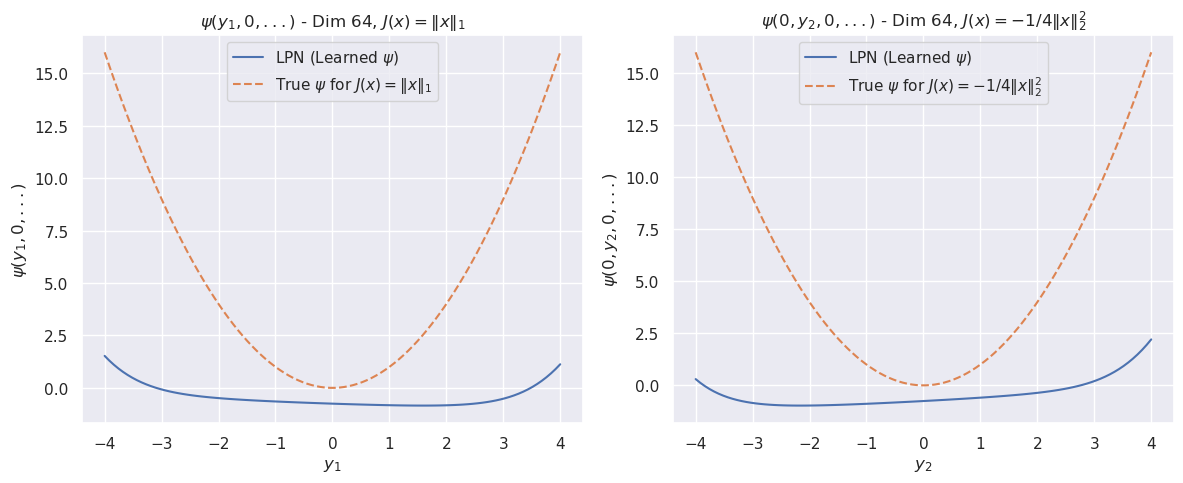

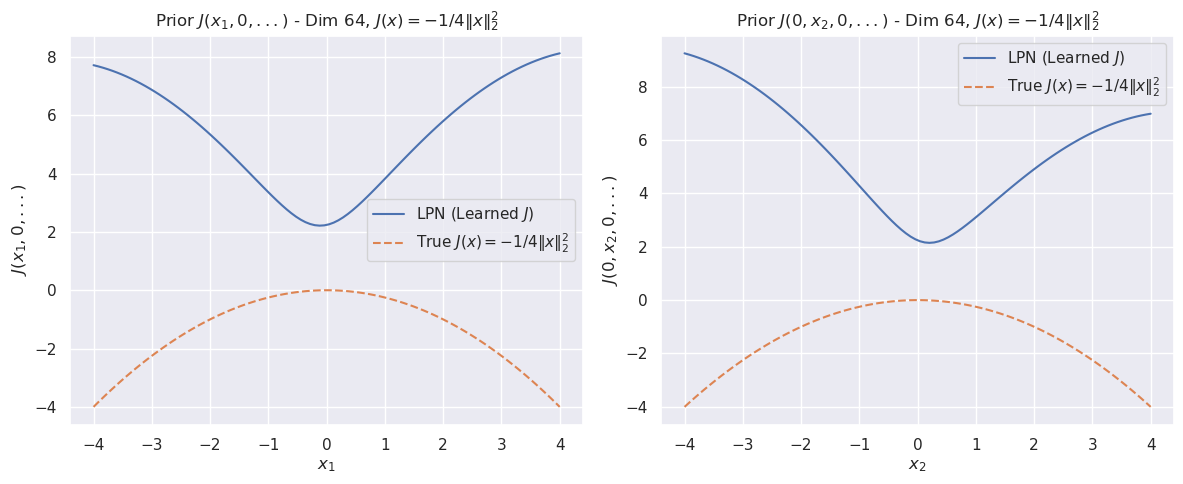

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.7407,  2.7126, -6.8475,  ..., -0.1289,  3.4408, -1.1653],
        [-3.6912,  0.5987,  2.2048,  ..., -0.0457, -0.3373,  4.0709],
        [-6.4984, -3.2932,  1.6518,  ...,  5.4363, -2.1491, -6.4235],
        ...,
        [-1.1695, -0.1212,  5.4107,  ...,  1.3135, -5.3291,  2.9287],
        [-2.7737,  3.9958,  5.9547,  ..., -6.0963, -2.1096, -0.3467],
        [ 3.6475, -0.0876, -6.0665,  ...,  2.7664, -4.7983, -6.1246]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 71203.7265625
iteration 0 loss 36357.1015625


iteration 500 loss 45.116661071777344


iteration 1000 loss 35.68480682373047


iteration 1500 loss 28.841455459594727


iteration 2000 loss 23.772401809692383


iteration 2500 loss 19.75193977355957


iteration 3000 loss 16.58456802368164


iteration 3500 loss 13.99160099029541


iteration 4000 loss 11.853221893310547


iteration 4500 loss 10.042105674743652


iteration 5000 loss 10.420817375183105


iteration 5500 loss 7.606822490692139


iteration 6000 loss 6.812880992889404


iteration 6500 loss 6.248698711395264


iteration 7000 loss 5.6427836418151855


iteration 7500 loss 5.198203086853027


iteration 8000 loss 4.796943664550781


iteration 8500 loss 4.338719844818115


iteration 9000 loss 4.0759358406066895


iteration 9500 loss 3.7416374683380127


iteration 10000 loss 3.5274085998535156


iteration 10500 loss 3.290921449661255


iteration 11000 loss 3.0517148971557617


iteration 11500 loss 2.769777536392212


iteration 12000 loss 2.6772143840789795


iteration 12500 loss 2.4899730682373047


iteration 13000 loss 2.279717206954956


iteration 13500 loss 2.2865097522735596


iteration 14000 loss 2.131589412689209


iteration 14500 loss 1.995821475982666


iteration 15000 loss 1.8454530239105225


iteration 15500 loss 4.139850616455078


iteration 16000 loss 1.7294319868087769


iteration 16500 loss 1.6150946617126465


iteration 17000 loss 1.5002696514129639


iteration 17500 loss 1.3699228763580322


iteration 18000 loss 1.4285043478012085


iteration 18500 loss 1.3217004537582397


iteration 19000 loss 1.223123550415039


iteration 19500 loss 1.1140321493148804


iteration 20000 loss 1.1718533039093018


iteration 20500 loss 1.0771965980529785


iteration 21000 loss 0.9926156997680664


iteration 21500 loss 1.0567971467971802


iteration 22000 loss 0.9172287583351135


iteration 22500 loss 0.8380099534988403


iteration 23000 loss 0.8696569800376892


iteration 23500 loss 0.7713784575462341


iteration 24000 loss 0.7078936696052551


iteration 24500 loss 0.7864921689033508


iteration 25000 loss 0.6988255977630615


iteration 25500 loss 0.6405954957008362


iteration 26000 loss 1.3081469535827637


iteration 26500 loss 0.6579349637031555


iteration 27000 loss 0.5918727517127991


iteration 27500 loss 0.5417221784591675


iteration 28000 loss 0.6402952075004578


iteration 28500 loss 0.5360186100006104


iteration 29000 loss 0.4867769479751587


iteration 29500 loss 44.55051803588867


iteration 30000 loss 0.5490235090255737


iteration 30500 loss 0.47967293858528137


iteration 31000 loss 0.43539315462112427


iteration 31500 loss 0.39575615525245667


iteration 32000 loss 0.4168335795402527


iteration 32500 loss 0.37400975823402405


iteration 33000 loss 0.42802825570106506


iteration 33500 loss 0.36641064286231995


iteration 34000 loss 0.3333110809326172


iteration 34500 loss 0.37612536549568176


iteration 35000 loss 0.3294071555137634


iteration 35500 loss 0.2995698153972626


iteration 36000 loss 0.35392171144485474


iteration 36500 loss 0.3092195391654968


iteration 37000 loss 0.2834186553955078


iteration 37500 loss 0.36809003353118896


iteration 38000 loss 0.30249619483947754


iteration 38500 loss 0.2715824246406555


iteration 39000 loss 1.2648289203643799


iteration 39500 loss 0.2987973690032959


iteration 40000 loss 0.2605278789997101


iteration 40500 loss 0.241775244474411


iteration 41000 loss 0.2787382900714874


iteration 41500 loss 0.23893168568611145


iteration 42000 loss 0.21888095140457153


iteration 42500 loss 0.23800170421600342


iteration 43000 loss 0.2100629061460495


iteration 43500 loss 0.23557299375534058


iteration 44000 loss 0.20198248326778412


iteration 44500 loss 0.2282159924507141


iteration 45000 loss 0.19160762429237366


iteration 45500 loss 0.215217724442482


iteration 46000 loss 0.1808057725429535


iteration 46500 loss 0.17573390901088715


iteration 47000 loss 0.17298628389835358


iteration 47500 loss 0.1905992329120636


iteration 48000 loss 0.15998874604701996


iteration 48500 loss 0.1790255308151245


iteration 49000 loss 0.15241816639900208


iteration 49500 loss 0.15233588218688965


iteration 50000 loss 0.1766485571861267


iteration 50500 loss 0.14415697753429413


iteration 51000 loss 0.15047667920589447


iteration 51500 loss 0.1578649878501892


iteration 52000 loss 6.9488654136657715


iteration 52500 loss 0.12928439676761627


iteration 53000 loss 0.12643040716648102


iteration 53500 loss 0.12977510690689087


iteration 54000 loss 0.13531669974327087


iteration 54500 loss 0.14818888902664185


iteration 55000 loss 0.3181169927120209


iteration 55500 loss 0.11614740639925003


iteration 56000 loss 0.11155933886766434


iteration 56500 loss 0.11282245814800262


iteration 57000 loss 0.12712866067886353


iteration 57500 loss 0.127572700381279


iteration 58000 loss 0.10998082906007767


iteration 58500 loss 0.10721016675233841


iteration 59000 loss 0.10213887691497803


iteration 59500 loss 0.09862877428531647


iteration 60000 loss 0.15538336336612701


iteration 60500 loss 0.186326265335083


iteration 61000 loss 0.11408564448356628


iteration 61500 loss 0.09058106690645218


iteration 62000 loss 0.11233006417751312


iteration 62500 loss 0.09304744005203247


iteration 63000 loss 0.08967868238687515


iteration 63500 loss 0.08376210927963257


iteration 64000 loss 0.08909764885902405


iteration 64500 loss 0.08409497886896133


iteration 65000 loss 0.08088023215532303


iteration 65500 loss 0.07890169322490692


iteration 66000 loss 0.07545807957649231


iteration 66500 loss 0.077223040163517


iteration 67000 loss 0.07436111569404602


iteration 67500 loss 0.07502546906471252


iteration 68000 loss 0.09422720968723297


iteration 68500 loss 0.07294004410505295


iteration 69000 loss 1.3156312704086304


iteration 69500 loss 0.07421687990427017


iteration 70000 loss 0.07256315648555756


iteration 70500 loss 0.06833162158727646


iteration 71000 loss 0.06730686128139496


iteration 71500 loss 0.06838276237249374


iteration 72000 loss 0.06512045115232468


iteration 72500 loss 0.06372209638357162


iteration 73000 loss 0.06163613870739937


iteration 73500 loss 0.06249567121267319


iteration 74000 loss 0.0595691092312336


iteration 74500 loss 0.06110048666596413


iteration 75000 loss 0.15704227983951569


iteration 75500 loss 0.06162307411432266


iteration 76000 loss 0.14464086294174194


iteration 76500 loss 0.05774501711130142


iteration 77000 loss 0.08572906255722046


iteration 77500 loss 0.05622323974967003


iteration 78000 loss 0.0530344694852829


iteration 78500 loss 0.662394642829895


iteration 79000 loss 0.12333805859088898


iteration 79500 loss 0.05397488921880722


iteration 80000 loss 0.060361120849847794


iteration 80500 loss 0.05061408132314682


iteration 81000 loss 0.049337226897478104


iteration 81500 loss 0.05047278478741646


iteration 82000 loss 0.05382511019706726


iteration 82500 loss 0.10705392807722092


iteration 83000 loss 0.18463942408561707


iteration 83500 loss 0.8950188159942627


iteration 84000 loss 0.7740501165390015


iteration 84500 loss 1.3269847631454468


iteration 85000 loss 0.3727879226207733


iteration 85500 loss 0.7800472974777222


iteration 86000 loss 0.6541457772254944


iteration 86500 loss 1.3902220726013184


iteration 87000 loss 0.3901551067829132


iteration 87500 loss 0.05538179352879524


iteration 88000 loss 0.42663928866386414


iteration 88500 loss 0.47816795110702515


iteration 89000 loss 0.4599800705909729


iteration 89500 loss 1.309704065322876


iteration 90000 loss 0.22554941475391388


iteration 90500 loss 0.43608030676841736


iteration 91000 loss 0.4607800245285034


iteration 91500 loss 1.1402721405029297


iteration 92000 loss 0.8208685517311096


iteration 92500 loss 0.42621731758117676


iteration 93000 loss 0.4414060413837433


iteration 93500 loss 0.8504981994628906


iteration 94000 loss 0.046254366636276245


iteration 94500 loss 0.30073609948158264


iteration 95000 loss 0.5084381103515625


iteration 95500 loss 0.8132402896881104


iteration 96000 loss 0.2949800193309784


iteration 96500 loss 0.5127711296081543


iteration 97000 loss 0.5931718349456787


iteration 97500 loss 1.292840838432312


iteration 98000 loss 0.12601476907730103


iteration 98500 loss 0.06220032647252083


iteration 99000 loss 0.08421672135591507


iteration 99500 loss 0.658441960811615


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 2.5545172691345215


iteration 100500 loss 0.030098931863904


iteration 101000 loss 0.028023753315210342


iteration 101500 loss 0.026410972699522972


iteration 102000 loss 0.024856043979525566


iteration 102500 loss 0.02340911515057087


iteration 103000 loss 0.022023141384124756


iteration 103500 loss 0.02068438194692135


iteration 104000 loss 0.019276438280940056


iteration 104500 loss 0.017861435189843178


iteration 105000 loss 0.016802845522761345


iteration 105500 loss 0.01598087139427662


iteration 106000 loss 0.015288961119949818


iteration 106500 loss 0.015341770835220814


iteration 107000 loss 0.013962621800601482


iteration 107500 loss 0.013388696126639843


iteration 108000 loss 0.013591338880360126


iteration 108500 loss 0.012388625182211399


iteration 109000 loss 0.01188738364726305


iteration 109500 loss 0.01147557981312275


iteration 110000 loss 0.011060011573135853


iteration 110500 loss 0.0160419512540102


iteration 111000 loss 0.010279596783220768


iteration 111500 loss 0.009934681467711926


iteration 112000 loss 0.009622781537473202


iteration 112500 loss 0.009304830804467201


iteration 113000 loss 0.009072397835552692


iteration 113500 loss 0.008714702911674976


iteration 114000 loss 0.008409098722040653


iteration 114500 loss 0.008176581934094429


iteration 115000 loss 0.007910145446658134


iteration 115500 loss 0.0076636625453829765


iteration 116000 loss 0.007425615563988686


iteration 116500 loss 0.007220849394798279


iteration 117000 loss 0.00700555881485343


iteration 117500 loss 0.0067869313061237335


iteration 118000 loss 0.00660486426204443


iteration 118500 loss 0.006468269973993301


iteration 119000 loss 0.0062222350388765335


iteration 119500 loss 0.006021966226398945


iteration 120000 loss 0.007836993783712387


iteration 120500 loss 0.005707587115466595


iteration 121000 loss 0.005540294107049704


iteration 121500 loss 0.00539244432002306


iteration 122000 loss 0.005254995543509722


iteration 122500 loss 0.005098098888993263


iteration 123000 loss 0.0049416725523769855


iteration 123500 loss 0.004848235286772251


iteration 124000 loss 0.0046995519660413265


iteration 124500 loss 0.004631071351468563


iteration 125000 loss 0.004446704871952534


iteration 125500 loss 0.004343837033957243


iteration 126000 loss 0.004526815842837095


iteration 126500 loss 0.004101166967302561


iteration 127000 loss 0.0061680618673563


iteration 127500 loss 0.003893064334988594


iteration 128000 loss 0.025132358074188232


iteration 128500 loss 0.0036813390906900167


iteration 129000 loss 0.0035990325268357992


iteration 129500 loss 0.0034921164624392986


iteration 130000 loss 0.0034156455658376217


iteration 130500 loss 0.00335172307677567


iteration 131000 loss 0.003240798832848668


iteration 131500 loss 0.0032375026494264603


iteration 132000 loss 0.0030806451104581356


iteration 132500 loss 0.003003111109137535


iteration 133000 loss 0.0029419080819934607


iteration 133500 loss 0.0030500339344143867


iteration 134000 loss 0.0027810591273009777


iteration 134500 loss 0.0027670683339238167


iteration 135000 loss 0.002648502355441451


iteration 135500 loss 0.0025937147438526154


iteration 136000 loss 0.0033798308577388525


iteration 136500 loss 0.0025145511608570814


iteration 137000 loss 0.0024051936343312263


iteration 137500 loss 0.0023554200306534767


iteration 138000 loss 0.0022842735052108765


iteration 138500 loss 0.0022413055412471294


iteration 139000 loss 0.06566710025072098


iteration 139500 loss 0.002122122561559081


iteration 140000 loss 0.0020820179488509893


iteration 140500 loss 0.10801830887794495


iteration 141000 loss 0.0019742201548069715


iteration 141500 loss 0.0019330506911501288


iteration 142000 loss 0.0019214183557778597


iteration 142500 loss 0.0018395977094769478


iteration 143000 loss 0.0017976902890950441


iteration 143500 loss 0.0017597839469090104


iteration 144000 loss 0.0017424831166863441


iteration 144500 loss 0.0016735111130401492


iteration 145000 loss 0.0016323230229318142


iteration 145500 loss 0.0015974502312019467


iteration 146000 loss 0.0015687192790210247


iteration 146500 loss 0.0015640350757166743


iteration 147000 loss 0.0020538822282105684


iteration 147500 loss 0.0014587680343538523


iteration 148000 loss 0.0014183575985953212


iteration 148500 loss 0.0013882276834920049


iteration 149000 loss 0.0013570255832746625


iteration 149500 loss 0.0013304712483659387


iteration 150000 loss 0.0013206485891714692


iteration 150500 loss 0.0012675648322328925


iteration 151000 loss 0.0012463685125112534


iteration 151500 loss 0.0012098177103325725


iteration 152000 loss 0.0011842477833852172


iteration 152500 loss 0.0011647469364106655


iteration 153000 loss 0.0012239199131727219


iteration 153500 loss 0.0012215175665915012


iteration 154000 loss 0.0010817123111337423


iteration 154500 loss 0.0010627825977280736


iteration 155000 loss 0.0010449824621900916


iteration 155500 loss 0.0010146312415599823


iteration 156000 loss 0.0009921352611854672


iteration 156500 loss 0.0009656402398832142


iteration 157000 loss 0.0009463586611673236


iteration 157500 loss 0.000927386456169188


iteration 158000 loss 0.0009111796389333904


iteration 158500 loss 0.0008936760714277625


iteration 159000 loss 0.0008703374769538641


iteration 159500 loss 0.0008555991807952523


iteration 160000 loss 0.0008371063158847392


iteration 160500 loss 0.0008093005744740367


iteration 161000 loss 0.0017807012191042304


iteration 161500 loss 0.03828393295407295


iteration 162000 loss 0.016214709728956223


iteration 162500 loss 0.0007525812834501266


iteration 163000 loss 0.0007817798177711666


iteration 163500 loss 0.0007179833482950926


iteration 164000 loss 0.0006959169404581189


iteration 164500 loss 0.0006807430181652308


iteration 165000 loss 0.0032561873085796833


iteration 165500 loss 0.0006613098084926605


iteration 166000 loss 0.000641307036858052


iteration 166500 loss 0.2394617646932602


iteration 167000 loss 0.0006218160269781947


iteration 167500 loss 0.0006020219880156219


iteration 168000 loss 0.0008219879819080234


iteration 168500 loss 0.005504764150828123


iteration 169000 loss 0.0005608372739516199


iteration 169500 loss 0.0005528077599592507


iteration 170000 loss 0.000578806851990521


iteration 170500 loss 0.0005263775237835944


iteration 171000 loss 0.0005173934623599052


iteration 171500 loss 0.0011602365411818027


iteration 172000 loss 0.0004940250073559582


iteration 172500 loss 0.0004959605867043138


iteration 173000 loss 0.000518905813805759


iteration 173500 loss 0.00047229506890289485


iteration 174000 loss 0.06263818591833115


iteration 174500 loss 0.00044486732804216444


iteration 175000 loss 0.0009657794726081192


iteration 175500 loss 0.0004315215046517551


iteration 176000 loss 0.006436717230826616


iteration 176500 loss 0.0004120439407415688


iteration 177000 loss 0.002822101814672351


iteration 177500 loss 0.00039674571598879993


iteration 178000 loss 0.022018998861312866


iteration 178500 loss 0.00037788800545968115


iteration 179000 loss 0.000376976968254894


iteration 179500 loss 0.001520431716926396


iteration 180000 loss 0.0003567739331629127


iteration 180500 loss 0.0003524418279994279


iteration 181000 loss 0.0030018354300409555


iteration 181500 loss 0.02524460107088089


iteration 182000 loss 0.000328692578477785


iteration 182500 loss 0.00032472971361130476


iteration 183000 loss 0.000550439057406038


iteration 183500 loss 0.0025436028372496367


iteration 184000 loss 0.0003074191336054355


iteration 184500 loss 0.004919883795082569


iteration 185000 loss 0.00029466746491380036


iteration 185500 loss 0.00028652092441916466


iteration 186000 loss 0.0002826297131832689


iteration 186500 loss 0.00027530163060873747


iteration 187000 loss 0.0022541529033333063


iteration 187500 loss 0.00026733477716334164


iteration 188000 loss 0.0018576837610453367


iteration 188500 loss 0.00025990043650381267


iteration 189000 loss 0.000249933305894956


iteration 189500 loss 0.00024755115737207234


iteration 190000 loss 0.014417230151593685


iteration 190500 loss 0.0002389435685472563


iteration 191000 loss 0.00023251891252584755


iteration 191500 loss 0.00022837342112325132


iteration 192000 loss 0.0010233012726530433


iteration 192500 loss 0.00022000489116180688


iteration 193000 loss 0.00021627542446367443


iteration 193500 loss 0.0010666018351912498


iteration 194000 loss 0.00021271442528814077


iteration 194500 loss 0.00020343308278825134


iteration 195000 loss 0.00027058908017352223


iteration 195500 loss 0.00019727094331756234


iteration 196000 loss 0.0165810976177454


iteration 196500 loss 0.00021566395298577845


iteration 197000 loss 0.0011098617687821388


iteration 197500 loss 0.003563960548490286


iteration 198000 loss 0.01636982150375843


iteration 198500 loss 0.0042439536191523075


iteration 199000 loss 0.022164642810821533


iteration 199500 loss 0.007616122253239155


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.001918308436870575


iteration 200500 loss 0.00016171704919543117


iteration 201000 loss 0.00016078900080174208


iteration 201500 loss 0.0001598996896063909


iteration 202000 loss 0.00015887619520071894


iteration 202500 loss 0.0001576281210873276


iteration 203000 loss 0.0001561033568577841


iteration 203500 loss 0.000154217763338238


iteration 204000 loss 0.0001518722710898146


iteration 204500 loss 0.0001489641726948321


iteration 205000 loss 0.00014660267333965749


iteration 205500 loss 0.00014330966223496944


iteration 206000 loss 0.00014071039913687855


iteration 206500 loss 0.00014049401215743273


iteration 207000 loss 0.00013516168110072613


iteration 207500 loss 0.00013237771054264158


iteration 208000 loss 0.0001299263967666775


iteration 208500 loss 0.00012735280324704945


iteration 209000 loss 0.00012560472532641143


iteration 209500 loss 0.00012273123138584197


iteration 210000 loss 0.00012460019206628203


iteration 210500 loss 0.00011811142758233473


iteration 211000 loss 0.00011576653196243569


iteration 211500 loss 0.00013469604891724885


iteration 212000 loss 0.0001114851183956489


iteration 212500 loss 0.00010933606245089322


iteration 213000 loss 0.00010741257574409246


iteration 213500 loss 0.00010541186202317476


iteration 214000 loss 0.00010338510037399828


iteration 214500 loss 0.00010145468695554882


iteration 215000 loss 9.950949606718495e-05


iteration 215500 loss 0.0008144603343680501


iteration 216000 loss 9.590714034857228e-05


iteration 216500 loss 9.412027429789305e-05


iteration 217000 loss 9.281468373956159e-05


iteration 217500 loss 9.067248174687847e-05


iteration 218000 loss 8.955186058301479e-05


iteration 218500 loss 8.73473982210271e-05


iteration 219000 loss 8.565300231566653e-05


iteration 219500 loss 8.860309753799811e-05


iteration 220000 loss 8.250187238445505e-05


iteration 220500 loss 8.140401041600853e-05


iteration 221000 loss 7.94569423305802e-05


iteration 221500 loss 7.789746450725943e-05


iteration 222000 loss 7.658002868993208e-05


iteration 222500 loss 7.500549691030756e-05


iteration 223000 loss 7.411123078782111e-05


iteration 223500 loss 7.22303957445547e-05


iteration 224000 loss 7.281090074684471e-05


iteration 224500 loss 6.956508150324225e-05


iteration 225000 loss 6.834667874500155e-05


iteration 225500 loss 6.701791426166892e-05


iteration 226000 loss 6.581069465028122e-05


iteration 226500 loss 6.529188249260187e-05


iteration 227000 loss 6.337738159345463e-05


iteration 227500 loss 6.292020407272503e-05


iteration 228000 loss 6.0997186665190384e-05


iteration 228500 loss 6.147267413325608e-05


iteration 229000 loss 5.881103061255999e-05


iteration 229500 loss 5.770754796685651e-05


iteration 230000 loss 5.679045352735557e-05


iteration 230500 loss 5.5604152294108644e-05


iteration 231000 loss 0.0027824142016470432


iteration 231500 loss 5.36033148819115e-05


iteration 232000 loss 5.253773633739911e-05


iteration 232500 loss 5.1621209422592074e-05


iteration 233000 loss 5.062869604444131e-05


iteration 233500 loss 4.972746319253929e-05


iteration 234000 loss 5.0206803280161694e-05


iteration 234500 loss 4.8117457481566817e-05


iteration 235000 loss 4.703509694081731e-05


iteration 235500 loss 0.00012465186591725796


iteration 236000 loss 4.533553874352947e-05


iteration 236500 loss 4.456541864783503e-05


iteration 237000 loss 4.372073453851044e-05


iteration 237500 loss 4.475052992347628e-05


iteration 238000 loss 4.215597436996177e-05


iteration 238500 loss 4.1311031964141876e-05


iteration 239000 loss 4.0492341213393956e-05


iteration 239500 loss 5.966110256849788e-05


iteration 240000 loss 3.9028600440360606e-05


iteration 240500 loss 5.5709177104290575e-05


iteration 241000 loss 3.7612557207467034e-05


iteration 241500 loss 3.6883706343360245e-05


iteration 242000 loss 3.627503974712454e-05


iteration 242500 loss 3.5806508094538e-05


iteration 243000 loss 3.49621259374544e-05


iteration 243500 loss 3.441422450123355e-05


iteration 244000 loss 3.368793477420695e-05


iteration 244500 loss 3.43205792887602e-05


iteration 245000 loss 3.2462648960063234e-05


iteration 245500 loss 3.1795905670151114e-05


iteration 246000 loss 3.136880332021974e-05


iteration 246500 loss 3.070014645345509e-05


iteration 247000 loss 3.0275936296675354e-05


iteration 247500 loss 2.9573950087069534e-05


iteration 248000 loss 2.904875873355195e-05


iteration 248500 loss 2.969170054711867e-05


iteration 249000 loss 2.802569724735804e-05


iteration 249500 loss 2.806556221912615e-05


iteration 250000 loss 2.699497235880699e-05


iteration 250500 loss 2.6758280000649393e-05


iteration 251000 loss 2.602167114673648e-05


iteration 251500 loss 2.8522556021925993e-05


iteration 252000 loss 2.5071411073440686e-05


iteration 252500 loss 2.492778548912611e-05


iteration 253000 loss 2.4376538931392133e-05


iteration 253500 loss 2.378066892561037e-05


iteration 254000 loss 0.0016491428250446916


iteration 254500 loss 2.2907473976374604e-05


iteration 255000 loss 0.004821604583412409


iteration 255500 loss 2.21287536987802e-05


iteration 256000 loss 2.2071162675274536e-05


iteration 256500 loss 2.1434618247440085e-05


iteration 257000 loss 2.109701199515257e-05


iteration 257500 loss 2.0588682673405856e-05


iteration 258000 loss 2.0411502191564068e-05


iteration 258500 loss 1.9890701878466643e-05


iteration 259000 loss 2.02594164875336e-05


iteration 259500 loss 1.9190230887033977e-05


iteration 260000 loss 1.9556237020879053e-05


iteration 260500 loss 1.8428600014885888e-05


iteration 261000 loss 1.8322616597288288e-05


iteration 261500 loss 1.7741342162480578e-05


iteration 262000 loss 1.7727950762491673e-05


iteration 262500 loss 1.7151218344224617e-05


iteration 263000 loss 0.000296596233965829


iteration 263500 loss 1.6542293451493606e-05


iteration 264000 loss 1.664172305027023e-05


iteration 264500 loss 1.5914141840767115e-05


iteration 265000 loss 1.5771636753925122e-05


iteration 265500 loss 1.5348250599345192e-05


iteration 266000 loss 1.509905450802762e-05


iteration 266500 loss 1.490833983552875e-05


iteration 267000 loss 1.628510290174745e-05


iteration 267500 loss 1.4273419765231665e-05


iteration 268000 loss 1.4088764146436006e-05


iteration 268500 loss 2.818069333443418e-05


iteration 269000 loss 1.3482865142577793e-05


iteration 269500 loss 1.3447843230096623e-05


iteration 270000 loss 1.300770600209944e-05


iteration 270500 loss 1.2992889423912857e-05


iteration 271000 loss 1.2569050340971444e-05


iteration 271500 loss 1.6089003111119382e-05


iteration 272000 loss 1.2128844900871627e-05


iteration 272500 loss 0.00011169494973728433


iteration 273000 loss 1.172429711004952e-05


iteration 273500 loss 1.201073064294178e-05


iteration 274000 loss 1.1260834071435966e-05


iteration 274500 loss 1.1109180377388839e-05


iteration 275000 loss 1.1086232007073704e-05


iteration 275500 loss 1.1628332686086651e-05


iteration 276000 loss 1.047462774295127e-05


iteration 276500 loss 1.0562449460849166e-05


iteration 277000 loss 1.0111164556292351e-05


iteration 277500 loss 9.997920642490499e-06


iteration 278000 loss 1.019514002109645e-05


iteration 278500 loss 9.57754127739463e-06


iteration 279000 loss 9.615838280296884e-06


iteration 279500 loss 9.25005861063255e-06


iteration 280000 loss 9.100049283006229e-06


iteration 280500 loss 0.00014148594345897436


iteration 281000 loss 8.80287007021252e-06


iteration 281500 loss 8.784645615378395e-06


iteration 282000 loss 8.582447662774939e-06


iteration 282500 loss 1.5651434296160005e-05


iteration 283000 loss 8.136316864693072e-06


iteration 283500 loss 8.07278229331132e-06


iteration 284000 loss 0.00024977282737381756


iteration 284500 loss 7.742002708255313e-06


iteration 285000 loss 8.596813131589442e-06


iteration 285500 loss 7.460134838765953e-06


iteration 286000 loss 7.390996415779227e-06


iteration 286500 loss 7.254525826283498e-06


iteration 287000 loss 1.3901131751481444e-05


iteration 287500 loss 3.1202427635435015e-05


iteration 288000 loss 6.822087470936822e-06


iteration 288500 loss 6.65249217490782e-06


iteration 289000 loss 6.564114755747141e-06


iteration 289500 loss 7.3263581725768745e-06


iteration 290000 loss 6.2887802414479665e-06


iteration 290500 loss 6.239756203285651e-06


iteration 291000 loss 2.1538355213124305e-05


iteration 291500 loss 6.1077362261130475e-06


iteration 292000 loss 6.490898158517666e-06


iteration 292500 loss 8.679659003973939e-06


iteration 293000 loss 5.639939899992896e-06


iteration 293500 loss 5.51903531231801e-06


iteration 294000 loss 5.43098576599732e-06


iteration 294500 loss 5.367960056901211e-06


iteration 295000 loss 5.253454219200648e-06


iteration 295500 loss 5.170629265194293e-06


iteration 296000 loss 5.184008387004724e-06


iteration 296500 loss 5.19348122907104e-06


iteration 297000 loss 4.886192527919775e-06


iteration 297500 loss 4.792360414285213e-06


iteration 298000 loss 0.0001691491052042693


iteration 298500 loss 0.00022932738647796214


iteration 299000 loss 6.203573775565019e-06


iteration 299500 loss 4.789006652572425e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.404942046676297e-06


iteration 300500 loss 4.3711461330531165e-06


iteration 301000 loss 4.357076250016689e-06


iteration 301500 loss 4.341810381447431e-06


iteration 302000 loss 4.324006113165524e-06


iteration 302500 loss 4.303590685594827e-06


iteration 303000 loss 4.278885171515867e-06


iteration 303500 loss 4.246512162353611e-06


iteration 304000 loss 4.206057838018751e-06


iteration 304500 loss 4.151183929934632e-06


iteration 305000 loss 4.085854925506283e-06


iteration 305500 loss 1.2150379006925505e-05


iteration 306000 loss 3.953432042180793e-06


iteration 306500 loss 3.920143626601202e-06


iteration 307000 loss 3.87575846616528e-06


iteration 307500 loss 3.808076144196093e-06


iteration 308000 loss 3.7216072996670846e-06


iteration 308500 loss 3.6943793020327576e-06


iteration 309000 loss 3.6611149880627636e-06


iteration 309500 loss 3.6171618376101833e-06


iteration 310000 loss 3.6213941712048836e-06


iteration 310500 loss 3.4971765217051143e-06


iteration 311000 loss 3.451521706665517e-06


iteration 311500 loss 3.4172105642937822e-06


iteration 312000 loss 3.3688645544316387e-06


iteration 312500 loss 3.299821401014924e-06


iteration 313000 loss 3.2567652397119673e-06


iteration 313500 loss 3.22364030580502e-06


iteration 314000 loss 3.1888753255771007e-06


iteration 314500 loss 3.136783789159381e-06


iteration 315000 loss 3.0801329558016732e-06


iteration 315500 loss 3.0377025268535363e-06


iteration 316000 loss 3.010111640833202e-06


iteration 316500 loss 2.982602154588676e-06


iteration 317000 loss 2.9479128897946794e-06


iteration 317500 loss 2.8846750410593813e-06


iteration 318000 loss 2.8494680464064004e-06


iteration 318500 loss 2.8211209155415418e-06


iteration 319000 loss 2.7840571874548914e-06


iteration 319500 loss 2.7333985599398147e-06


iteration 320000 loss 2.696393721635104e-06


iteration 320500 loss 2.662641009010258e-06


iteration 321000 loss 2.6735810934042092e-06


iteration 321500 loss 2.5750625809450867e-06


iteration 322000 loss 2.5475483198533766e-06


iteration 322500 loss 2.5080926207010634e-06


iteration 323000 loss 2.4846644919307437e-06


iteration 323500 loss 2.434803036521771e-06


iteration 324000 loss 2.402321570116328e-06


iteration 324500 loss 2.3792140382283833e-06


iteration 325000 loss 2.352373257963336e-06


iteration 325500 loss 2.3073405372997513e-06


iteration 326000 loss 2.2801766590418993e-06


iteration 326500 loss 2.2549381810677005e-06


iteration 327000 loss 2.233209670521319e-06


iteration 327500 loss 2.1985724742989987e-06


iteration 328000 loss 3.067058423766866e-05


iteration 328500 loss 2.138985792043968e-06


iteration 329000 loss 2.11851852327527e-06


iteration 329500 loss 2.093447619699873e-06


iteration 330000 loss 2.0688023596449057e-06


iteration 330500 loss 2.0301442873460473e-06


iteration 331000 loss 2.0074485291843303e-06


iteration 331500 loss 1.988176791201113e-06


iteration 332000 loss 1.958330585694057e-06


iteration 332500 loss 1.94502013073361e-06


iteration 333000 loss 1.9060063323195209e-06


iteration 333500 loss 1.888005613182031e-06


iteration 334000 loss 1.8589367982713156e-06


iteration 334500 loss 1.814822439882846e-06


iteration 335000 loss 1.8076352716889232e-06


iteration 335500 loss 1.7908587324200198e-06


iteration 336000 loss 1.7740361499818391e-06


iteration 336500 loss 1.7525983366795117e-06


iteration 337000 loss 1.7290785763179883e-06


iteration 337500 loss 1.7080243424061337e-06


iteration 338000 loss 1.6914266325329663e-06


iteration 338500 loss 1.6777656810518238e-06


iteration 339000 loss 2.02289447770454e-06


iteration 339500 loss 1.6245105598500231e-06


iteration 340000 loss 1.6105893791973358e-06


iteration 340500 loss 1.5937657735776156e-06


iteration 341000 loss 1.5646651263523381e-06


iteration 341500 loss 1.551251102682727e-06


iteration 342000 loss 1.5353689377661794e-06


iteration 342500 loss 1.5208194099614047e-06


iteration 343000 loss 1.4969331232350669e-06


iteration 343500 loss 2.471029438311234e-05


iteration 344000 loss 1.464338538426091e-06


iteration 344500 loss 1.4495475397779956e-06


iteration 345000 loss 1.4423678749153623e-06


iteration 345500 loss 1.7983874158744584e-06


iteration 346000 loss 1.3952984545539948e-06


iteration 346500 loss 1.3813817076879786e-06


iteration 347000 loss 1.3693705795958522e-06


iteration 347500 loss 1.3498341786544188e-06


iteration 348000 loss 1.3352344012673711e-06


iteration 348500 loss 1.3141923318471527e-06


iteration 349000 loss 1.3031525440965197e-06


iteration 349500 loss 1.2858200761911576e-06


iteration 350000 loss 1.2732180039165542e-06


iteration 350500 loss 1.2586777984324726e-06


iteration 351000 loss 1.2463327720979578e-06


iteration 351500 loss 1.2293021427467465e-06


iteration 352000 loss 1.2148339010309428e-06


iteration 352500 loss 1.2033626717311563e-06


iteration 353000 loss 1.1921720215468667e-06


iteration 353500 loss 1.173175633084611e-06


iteration 354000 loss 1.1650728310996783e-06


iteration 354500 loss 1.1541617368493462e-06


iteration 355000 loss 1.1369501180524821e-06


iteration 355500 loss 1.1309921319480054e-06


iteration 356000 loss 1.1169552180945175e-06


iteration 356500 loss 1.1065687886002706e-06


iteration 357000 loss 1.090862724595354e-06


iteration 357500 loss 1.0797913319038344e-06


iteration 358000 loss 1.0701396604417823e-06


iteration 358500 loss 1.0585265499685192e-06


iteration 359000 loss 8.49281859700568e-05


iteration 359500 loss 1.0369157052991795e-06


iteration 360000 loss 1.026437644213729e-06


iteration 360500 loss 1.0167580057895975e-06


iteration 361000 loss 1.0125295375473797e-06


iteration 361500 loss 9.991637170969625e-07


iteration 362000 loss 9.84951839200221e-07


iteration 362500 loss 9.772336397873005e-07


iteration 363000 loss 9.799039162317058e-07


iteration 363500 loss 9.492973731539678e-07


iteration 364000 loss 9.437189874006435e-07


iteration 364500 loss 9.370922953166883e-07


iteration 365000 loss 9.277595154344453e-07


iteration 365500 loss 1.464676097384654e-05


iteration 366000 loss 9.08606580196647e-07


iteration 366500 loss 9.005921697280428e-07


iteration 367000 loss 9.05925560346077e-07


iteration 367500 loss 8.731595926292357e-07


iteration 368000 loss 8.723654332243314e-07


iteration 368500 loss 8.654955649944895e-07


iteration 369000 loss 8.588148148191976e-07


iteration 369500 loss 8.477505275550357e-07


iteration 370000 loss 8.429357762906875e-07


iteration 370500 loss 8.322313078679144e-07


iteration 371000 loss 8.243823117481952e-07


iteration 371500 loss 8.115455329971155e-07


iteration 372000 loss 8.103656341518217e-07


iteration 372500 loss 8.009047860468854e-07


iteration 373000 loss 7.949016662678332e-07


iteration 373500 loss 8.174618528755673e-07


iteration 374000 loss 7.737355076642416e-07


iteration 374500 loss 7.711810781074746e-07


iteration 375000 loss 7.638359988959564e-07


iteration 375500 loss 7.551820431217493e-07


iteration 376000 loss 0.00023054458142723888


iteration 376500 loss 7.411221076836227e-07


iteration 377000 loss 7.35535365947726e-07


iteration 377500 loss 7.296454782590445e-07


iteration 378000 loss 7.19333229426411e-07


iteration 378500 loss 7.134052566470928e-07


iteration 379000 loss 6.992235626057663e-07


iteration 379500 loss 6.954579703233321e-07


iteration 380000 loss 6.985040954532451e-07


iteration 380500 loss 6.784691208849836e-07


iteration 381000 loss 6.733500299560546e-07


iteration 381500 loss 6.6453577574066e-07


iteration 382000 loss 6.637169462919701e-07


iteration 382500 loss 6.552503464263282e-07


iteration 383000 loss 6.496708806480456e-07


iteration 383500 loss 6.411289632524131e-07


iteration 384000 loss 6.397099241439719e-07


iteration 384500 loss 6.323513161987648e-07


iteration 385000 loss 6.28088969278906e-07


iteration 385500 loss 6.220889190444723e-07


iteration 386000 loss 9.532588478577964e-07


iteration 386500 loss 6.096761353546754e-07


iteration 387000 loss 6.045797249498719e-07


iteration 387500 loss 5.981116828479571e-07


iteration 388000 loss 5.873616828466766e-07


iteration 388500 loss 5.877951707589091e-07


iteration 389000 loss 5.820741648676631e-07


iteration 389500 loss 5.781277536698326e-07


iteration 390000 loss 5.730825023420039e-07


iteration 390500 loss 5.628127723866783e-07


iteration 391000 loss 5.644160410156474e-07


iteration 391500 loss 5.587244800153712e-07


iteration 392000 loss 5.543314500755514e-07


iteration 392500 loss 5.474228146340465e-07


iteration 393000 loss 5.451664719657856e-07


iteration 393500 loss 5.403530281000712e-07


iteration 394000 loss 5.323812501956127e-07


iteration 394500 loss 5.372161808736564e-07


iteration 395000 loss 5.287764111017168e-07


iteration 395500 loss 5.239571123638598e-07


iteration 396000 loss 5.175949127078638e-07


iteration 396500 loss 5.143595558365632e-07


iteration 397000 loss 5.115995804771956e-07


iteration 397500 loss 5.061694992036792e-07


iteration 398000 loss 5.019843456466333e-07


iteration 398500 loss 7.345358881138964e-07


iteration 399000 loss 4.975989327249408e-07


iteration 399500 loss 4.911444762001338e-07


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 4.869605731983029e-07


iteration 400500 loss 4.865543132837047e-07


iteration 401000 loss 4.863549634137598e-07


iteration 401500 loss 4.864089078182587e-07


iteration 402000 loss 4.8614987235851e-07


iteration 402500 loss 4.860884246227215e-07


iteration 403000 loss 4.853845325669681e-07


iteration 403500 loss 4.84246811538469e-07


iteration 404000 loss 4.828476107832103e-07


iteration 404500 loss 4.810449354408775e-07


iteration 405000 loss 4.778738684763084e-07


iteration 405500 loss 4.7118615498220606e-07


iteration 406000 loss 4.6128835151648673e-07


iteration 406500 loss 4.5950383764647995e-07


iteration 407000 loss 4.582994108659477e-07


iteration 407500 loss 4.5692124217566743e-07


iteration 408000 loss 4.548109018287505e-07


iteration 408500 loss 4.508650306433992e-07


iteration 409000 loss 4.4458226966526126e-07


iteration 409500 loss 4.352522466888331e-07


iteration 410000 loss 4.3397983517934335e-07


iteration 410500 loss 4.3287704443173425e-07


iteration 411000 loss 4.3173199060220213e-07


iteration 411500 loss 4.298172768812947e-07


iteration 412000 loss 4.299115232697659e-07


iteration 412500 loss 4.2246838916071283e-07


iteration 413000 loss 4.135572737595794e-07


iteration 413500 loss 4.115948399885383e-07


iteration 414000 loss 4.1074571299759555e-07


iteration 414500 loss 4.095717258678633e-07


iteration 415000 loss 4.0741977613834024e-07


iteration 415500 loss 4.045615753511811e-07


iteration 416000 loss 4.013926968582382e-07


iteration 416500 loss 3.9338934243460244e-07


iteration 417000 loss 3.91213063721807e-07


iteration 417500 loss 3.903503795754659e-07


iteration 418000 loss 3.890978916842869e-07


iteration 418500 loss 3.8728845197510964e-07


iteration 419000 loss 3.839193141175201e-07


iteration 419500 loss 3.7819694398422143e-07


iteration 420000 loss 3.7403606256702915e-07


iteration 420500 loss 3.7315425061024143e-07


iteration 421000 loss 3.72306004692291e-07


iteration 421500 loss 3.7089046145410975e-07


iteration 422000 loss 3.6867450603494945e-07


iteration 422500 loss 3.644184971562936e-07


iteration 423000 loss 3.5799928355118027e-07


iteration 423500 loss 3.539693125276244e-07


iteration 424000 loss 3.533455981141742e-07


iteration 424500 loss 3.5293160749461094e-07


iteration 425000 loss 3.5177518498130667e-07


iteration 425500 loss 3.50371436752539e-07


iteration 426000 loss 3.47189740068643e-07


iteration 426500 loss 3.425245154176082e-07


iteration 427000 loss 3.399911179258197e-07


iteration 427500 loss 3.3910470165210427e-07


iteration 428000 loss 3.382448312549968e-07


iteration 428500 loss 3.3694220746838255e-07


iteration 429000 loss 3.3476410976618354e-07


iteration 429500 loss 3.281646456798626e-07


iteration 430000 loss 3.242917046009097e-07


iteration 430500 loss 3.236650627513882e-07


iteration 431000 loss 3.229053504583135e-07


iteration 431500 loss 3.215725428162841e-07


iteration 432000 loss 3.204091001407505e-07


iteration 432500 loss 3.1621121365787985e-07


iteration 433000 loss 3.135788517738547e-07


iteration 433500 loss 3.1053576776685077e-07


iteration 434000 loss 3.0956979912843963e-07


iteration 434500 loss 3.087612583385635e-07


iteration 435000 loss 3.073211871651438e-07


iteration 435500 loss 3.0431678510467464e-07


iteration 436000 loss 2.99091595934442e-07


iteration 436500 loss 2.973907271552889e-07


iteration 437000 loss 2.9666836098840577e-07


iteration 437500 loss 2.960818221708905e-07


iteration 438000 loss 2.9524969136218715e-07


iteration 438500 loss 2.937796637070278e-07


iteration 439000 loss 2.922972726082662e-07


iteration 439500 loss 2.862836083750153e-07


iteration 440000 loss 2.8438833510335826e-07


iteration 440500 loss 2.839662158748979e-07


iteration 441000 loss 2.8332928536656254e-07


iteration 441500 loss 2.8232102522451896e-07


iteration 442000 loss 2.8113529992879194e-07


iteration 442500 loss 2.7863276841344486e-07


iteration 443000 loss 2.740842433013313e-07


iteration 443500 loss 2.732825805651373e-07


iteration 444000 loss 2.728383208250307e-07


iteration 444500 loss 2.722120200360223e-07


iteration 445000 loss 2.711815056954947e-07


iteration 445500 loss 2.6987095225194935e-07


iteration 446000 loss 2.6684193699111347e-07


iteration 446500 loss 6.770198979211273e-07


iteration 447000 loss 2.619727581532061e-07


iteration 447500 loss 2.6165648137066455e-07


iteration 448000 loss 2.608822171623615e-07


iteration 448500 loss 2.600643824735016e-07


iteration 449000 loss 2.5855919716377684e-07


iteration 449500 loss 2.5584958507351985e-07


iteration 450000 loss 2.5122602664851e-07


iteration 450500 loss 2.5037294903995644e-07


iteration 451000 loss 2.4972354140118114e-07


iteration 451500 loss 2.490132544608059e-07


iteration 452000 loss 2.484624701537541e-07


iteration 452500 loss 2.4699684786355647e-07


iteration 453000 loss 2.445779898607725e-07


iteration 453500 loss 2.448828126944136e-07


iteration 454000 loss 2.3998507003852865e-07


iteration 454500 loss 2.3956255290613626e-07


iteration 455000 loss 2.3899153234197e-07


iteration 455500 loss 2.3820099670501804e-07


iteration 456000 loss 2.371486402807932e-07


iteration 456500 loss 2.3444550834028632e-07


iteration 457000 loss 7.26838038644928e-07


iteration 457500 loss 2.3018519357265177e-07


iteration 458000 loss 2.298441188486322e-07


iteration 458500 loss 2.2931834564587916e-07


iteration 459000 loss 2.2869332383379515e-07


iteration 459500 loss 2.2751220285499585e-07


iteration 460000 loss 2.253983808486737e-07


iteration 460500 loss 2.386130972809042e-07


iteration 461000 loss 2.2177215441843146e-07


iteration 461500 loss 2.2142947386782907e-07


iteration 462000 loss 2.20960785668467e-07


iteration 462500 loss 2.2025484724963462e-07


iteration 463000 loss 2.189359094018073e-07


iteration 463500 loss 2.1662044957793114e-07


iteration 464000 loss 2.1282187390170293e-07


iteration 464500 loss 2.1208798273164575e-07


iteration 465000 loss 2.1176612108320114e-07


iteration 465500 loss 2.1133259053840447e-07


iteration 466000 loss 2.1083246792841237e-07


iteration 466500 loss 2.099145177680839e-07


iteration 467000 loss 2.0850912108016928e-07


iteration 467500 loss 2.060001236259268e-07


iteration 468000 loss 2.0489422070113505e-07


iteration 468500 loss 2.0459093263980321e-07


iteration 469000 loss 2.0430073277566407e-07


iteration 469500 loss 2.0368746334042953e-07


iteration 470000 loss 2.0280209866996302e-07


iteration 470500 loss 2.010292377008227e-07


iteration 471000 loss 1.979448569500164e-07


iteration 471500 loss 1.967880365327801e-07


iteration 472000 loss 1.9622430613708275e-07


iteration 472500 loss 1.9594388334098767e-07


iteration 473000 loss 1.9557684538540343e-07


iteration 473500 loss 1.9492409819577006e-07


iteration 474000 loss 1.9352216895640595e-07


iteration 474500 loss 1.9103887893834326e-07


iteration 475000 loss 1.8962067827033025e-07


iteration 475500 loss 1.8888955821694253e-07


iteration 476000 loss 1.887149068124927e-07


iteration 476500 loss 1.882003033415458e-07


iteration 477000 loss 1.8731959983142588e-07


iteration 477500 loss 1.857840175034653e-07


iteration 478000 loss 1.8292163872501987e-07


iteration 478500 loss 1.820251895878755e-07


iteration 479000 loss 1.8167467885632504e-07


iteration 479500 loss 1.812703374071134e-07


iteration 480000 loss 1.8111317956481798e-07


iteration 480500 loss 1.804274205596812e-07


iteration 481000 loss 1.796038588963711e-07


iteration 481500 loss 1.7727019496760477e-07


iteration 482000 loss 1.7615019487493555e-07


iteration 482500 loss 1.7567646182214958e-07


iteration 483000 loss 1.754074503423908e-07


iteration 483500 loss 1.7505104210613354e-07


iteration 484000 loss 1.7458197021369415e-07


iteration 484500 loss 1.733747154730736e-07


iteration 485000 loss 1.712440251822045e-07


iteration 485500 loss 1.69727499610417e-07


iteration 486000 loss 1.687191257815357e-07


iteration 486500 loss 1.6835750216159795e-07


iteration 487000 loss 1.680647727653195e-07


iteration 487500 loss 1.6764758470344532e-07


iteration 488000 loss 1.665369353531787e-07


iteration 488500 loss 1.6462786334159318e-07


iteration 489000 loss 1.633098207776129e-07


iteration 489500 loss 1.6263822999462718e-07


iteration 490000 loss 1.6229635946274357e-07


iteration 490500 loss 1.6186527318495791e-07


iteration 491000 loss 1.6149857628988684e-07


iteration 491500 loss 1.6039564343373058e-07


iteration 492000 loss 1.5902311645277223e-07


iteration 492500 loss 1.5773149186770752e-07


iteration 493000 loss 1.5743360393116745e-07


iteration 493500 loss 1.5716258872089384e-07


iteration 494000 loss 1.570384142723924e-07


iteration 494500 loss 1.5632274141808011e-07


iteration 495000 loss 1.5523448837484466e-07


iteration 495500 loss 1.8212655561455904e-07


iteration 496000 loss 1.5312771495246125e-07


iteration 496500 loss 1.5284744847576803e-07


iteration 497000 loss 1.525081785302973e-07


iteration 497500 loss 1.520245973551937e-07


iteration 498000 loss 1.5114302698293614e-07


iteration 498500 loss 1.497389234828006e-07


iteration 499000 loss 1.4823569927102653e-07


iteration 499500 loss 1.4778250090330403e-07


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


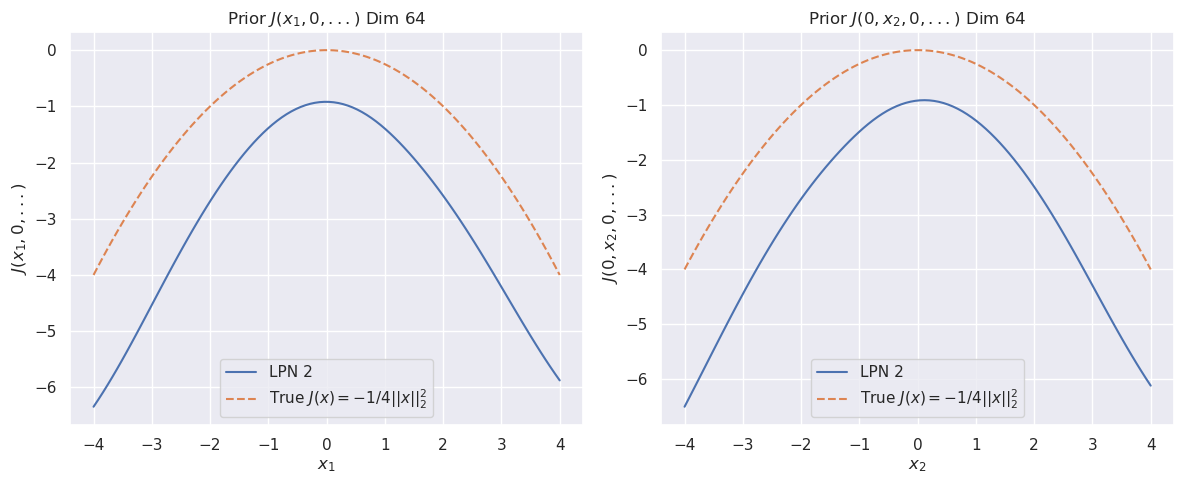

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)